<a href="https://colab.research.google.com/github/uzairaslam19/Time-series-Analysis-for-Malaria/blob/main/Disease_TimeSeries_Analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disease w.r.t Temperature Time Series Analysis**

In [402]:
#Import the necessary packages
import pandas as pd
import numpy as np
import pywt
from prophet import Prophet
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.core.dtypes import dtypes
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import logging
import logging

# Set up logging
logger_prophet = logging.getLogger('prophet')
logger_prophet.setLevel(logging.ERROR)
handler_prophet = logging.FileHandler('prophet_log.txt')
logger_prophet.addHandler(handler_prophet)

logger_cmdstanpy = logging.getLogger('cmdstanpy')
logger_cmdstanpy.setLevel(logging.ERROR)
handler_cmdstanpy = logging.FileHandler('cmdstanpy_log.txt')
logger_cmdstanpy.addHandler(handler_cmdstanpy)
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

In [178]:
#Load the data from csv file, also change column names removing any spaces, Conver columns to correct types
data = pd.read_csv(r'DRC_filtered_merged_data.csv', index_col=0,
                   names=[ 'DRC_cases',
                          'DRC_deaths', 'PRECTOTCORR','T2M','T2M_MAX','T2M_MIN'],
                   header=0, dtype = {1:'int16', 2:'int16', 3:float,4:float,5:float,6:float},parse_dates=True,dayfirst=False)

In [179]:
#Checking the first 5 rows of data to see how it looks like
data.head(5)

DRC_cases  DRC_deaths  PRECTOTCORR        T2M  T2M_MAX  T2M_MIN
2019-01-06        798          17         0.31  26.335000    33.31    20.12
2019-01-13        618          14         0.46  26.487143    35.79    18.87
2019-01-20        708          17         1.93  26.887143    34.94    19.99
2019-01-27        748          19        25.43  26.974286    35.13    21.48
2019-02-03        681          18        19.71  25.840000    32.58    21.38

In [180]:
# Check the data for any missing values or correct datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2019-01-06 to 2023-10-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DRC_cases    248 non-null    int16  
 1   DRC_deaths   248 non-null    int16  
 2   PRECTOTCORR  248 non-null    float64
 3   T2M          248 non-null    float64
 4   T2M_MAX      248 non-null    float64
 5   T2M_MIN      248 non-null    float64
dtypes: float64(4), int16(2)
memory usage: 10.7 KB


In [181]:
# Basic Descriptive Statistics
statistics = data.describe()
statistics.style.background_gradient(cmap='Greens')

Since this time we shall focus on the new variables,
we can see that the variable T2M doesnt have any 0 values, Which shows the variable is clean

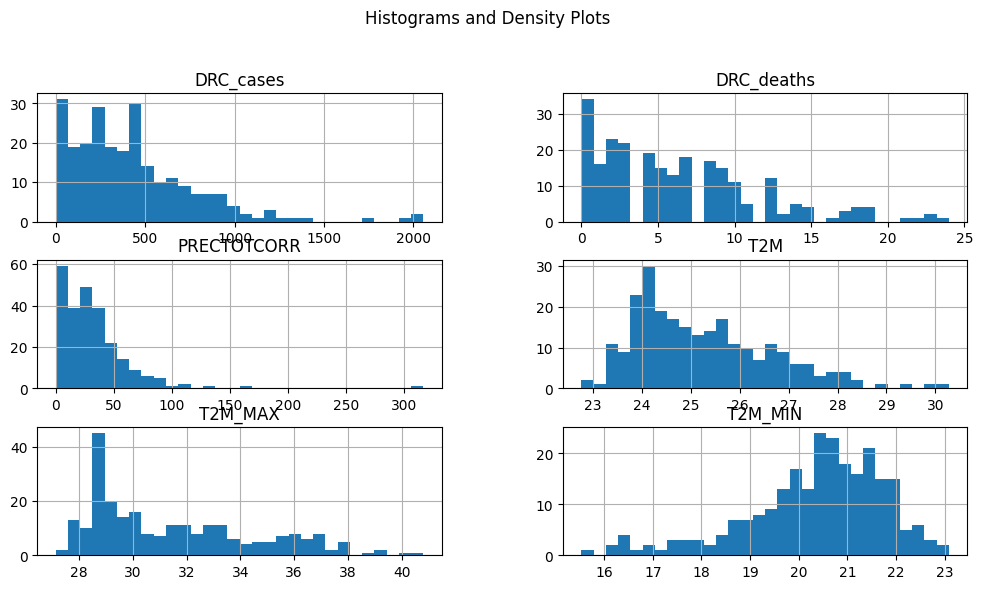

In [182]:
# Histograms and Density Plots
data.hist(bins=30, figsize=(12, 6))
plt.suptitle('Histograms and Density Plots', x=0.5, y=1.02)
plt.show()

## **Distribution Analysis**
**DRC_cases:** We can see from the plots above that DRC_cases is distributed mostly at lower levels, such that majority of the cases are below 500 for a weekly basis. But we do notice that there are some instances where the cases have gone upto 2000 for some weeks.

**DRC_death:** For DRC_deaths mostly the deaths are in the ranges of 0-13 But there are cases where the death have gone up to 23 though these are not many, only 2-3 cases.

## **Relationship Plots - Bi-Variate Analysis**

In [183]:
#Lets Define a function to plot scatter plots for our columns relationships
def scatter(column1: pd.Series, column2: pd.Series, x_label: str, y_label: str) -> None:
  """ Simple function to plot Scatter plots:
    params:
      column1: First column to be plotted on x axis
      column2: Second Column to be plotted on y-axis
      x_label: Label for x axis
      y_label: lable for y axis
    returns:
      Matplotlib Scatter Plot
  """
  plt.figure(figsize=(12, 6))
  plt.scatter(column1, column2)
  plt.title(f'Scatter Plot: {x_label} vs. {y_label}')
  plt.xlabel(f'{x_label}')
  plt.ylabel(f'{y_label}')
  plt.show()

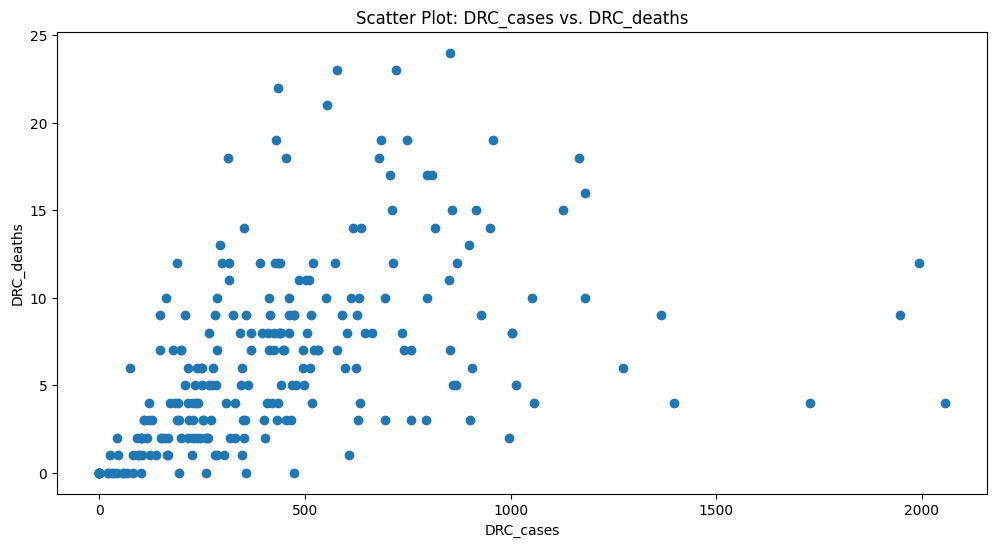

In [184]:
# Scatter Plot for DRC_cases and DRC_deaths
scatter(data['DRC_cases'],data['DRC_deaths'],'DRC_cases', 'DRC_deaths')

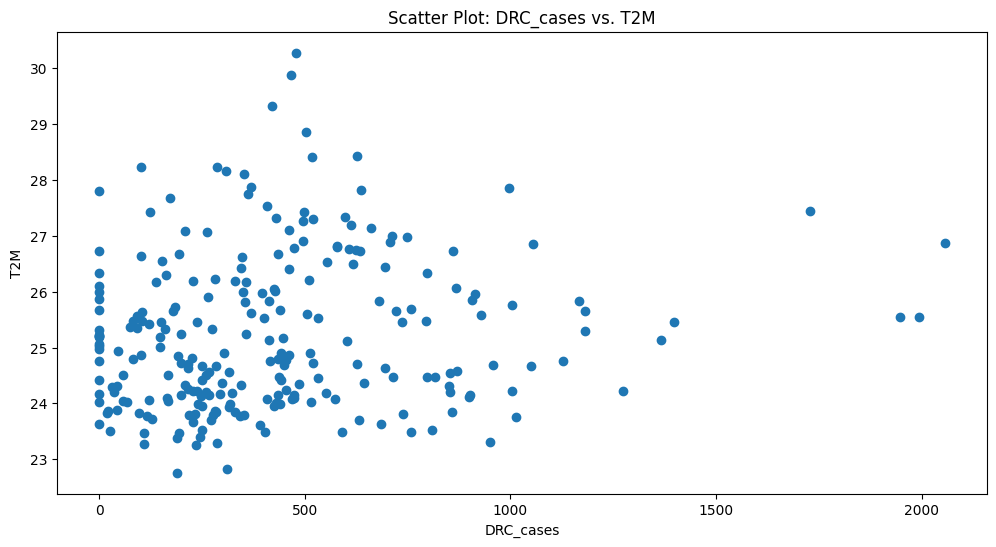

In [185]:
# Scatter Plot for DRC_cases and t2m
scatter(data['DRC_cases'],data['T2M'],'DRC_cases', 'T2M')

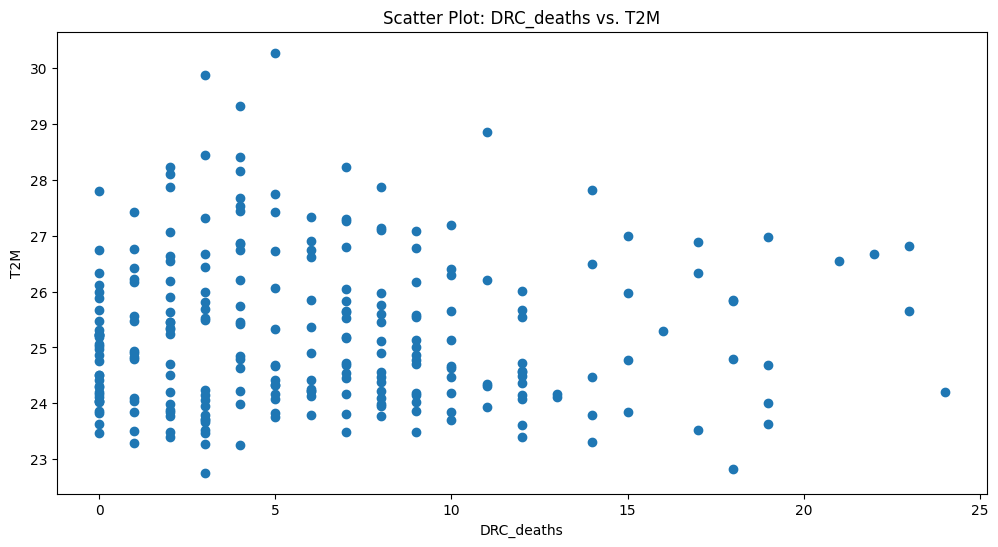

In [186]:
# Scatter Plot for DRC_deaths and t2m
scatter(data['DRC_deaths'],data['T2M'],'DRC_deaths', 'T2M')

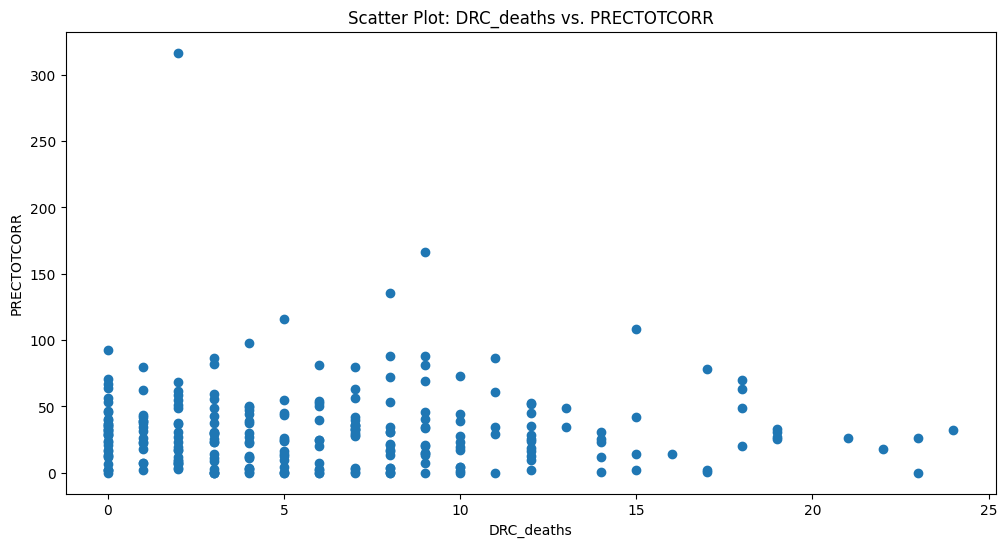

In [187]:
# Scatter Plot for DRC_deaths and rfe
scatter(data['DRC_deaths'],data['PRECTOTCORR'],'DRC_deaths', 'PRECTOTCORR')

## **Correlation Analysis**

In [188]:
# Display the correlation matrix
correlation_matrix = data[1:].corr()

In [189]:
print("Correlation Matrix")
correlation_matrix.style.background_gradient(cmap='Greens')

Correlation Matrix


## **Key Take Aways from Correlation Matrix**

**DRC_cases and DRC_deaths:**

Correlation coefficient: 0.498118
This indicates a moderate positive correlation between the number of cases and deaths in the Democratic Republic of Congo (DRC). When cases increase, deaths tend to increase, but the correlation is not very strong.

**DRC_cases and PRECTOTCORR:**

Correlation coefficient: -0.109887
There is a weak negative correlation between the number of cases and precipitation. This suggests that as precipitation increases, the number of cases tends to decrease slightly.

**DRC_cases and T2M (Mean Temperature):**

Correlation coefficient: 0.144303
There is a weak positive correlation between the number of cases and mean temperature. This suggests that as the temperature increases, the number of cases tends to increase slightly.

**DRC_deaths and PRECTOTCORR:**

Correlation coefficient: -0.013613
There is a very weak negative correlation between the number of deaths and precipitation. This suggests that as precipitation increases, the number of deaths tends to decrease slightly, but the correlation is almost negligible.

**PRECTOTCORR and T2M (Mean Temperature):**

Correlation coefficient: -0.435727
There is a moderate negative correlation between precipitation and mean temperature. As precipitation increases, mean temperature tends to decrease.


## **Time Series plot for each of the variables**

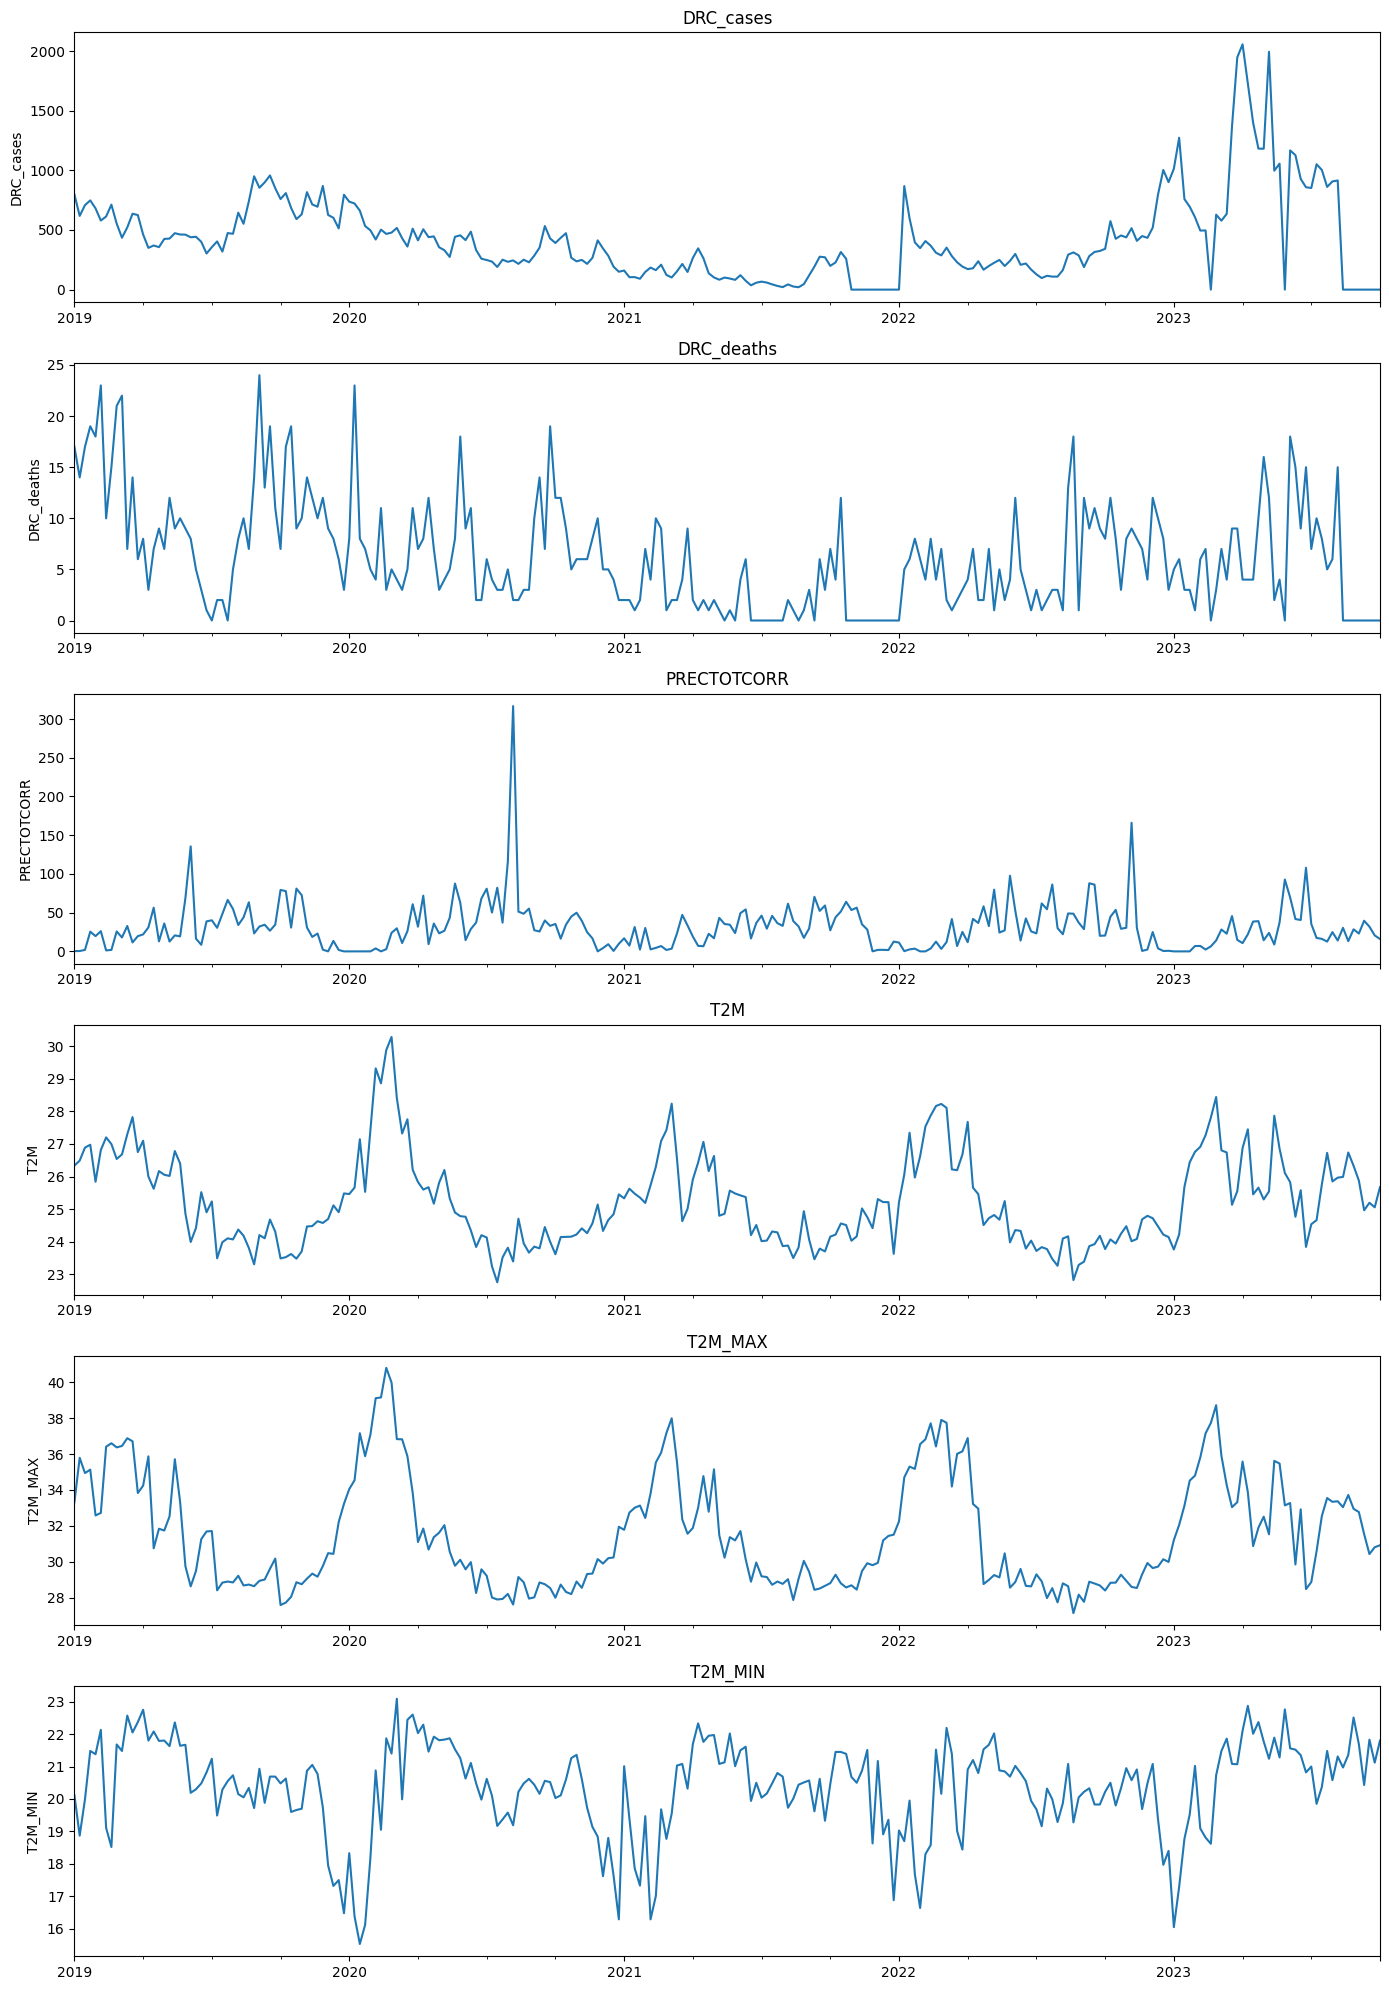

In [190]:
# Plotting each column in the dataset
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(14, 20))

columns = data.columns
for i, column in enumerate(columns):
    data[column].plot(ax=axes[i], title=column, legend=False)
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

The plots provide insights into the time series nature of the data. We observe the following:

**DRC_cases:** There's a prominent upward trend with noticeable seasonality. Peaks are observed around mid-year.

**DRC_deaths:** Similar to DRC_cases, it has an upward trend and seasonality.

**PRECTOTCORR:** This feature exhibits strong seasonality with peaks around mid-year.

**T2M, T2M_MAX, T2M_MIN:** These temperature-related features also have seasonality, but the pattern is different from the cases and deaths.

# **Analysis for Cases**

## ARIMA with DWT

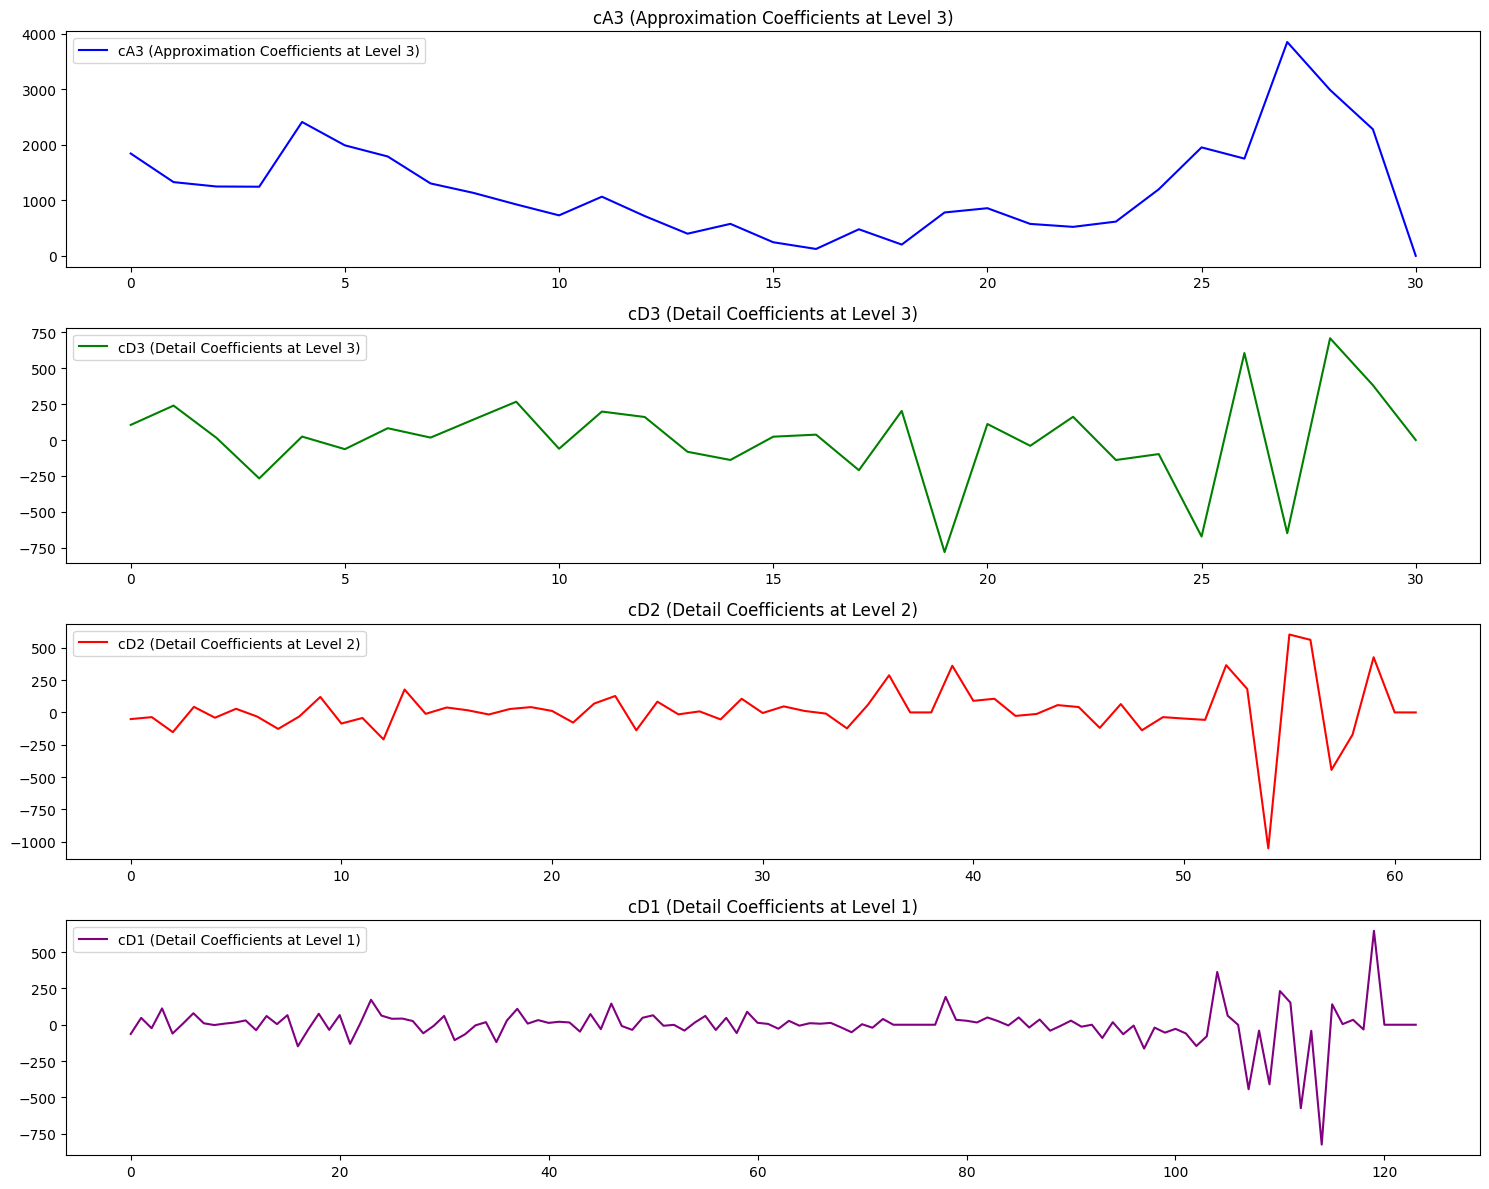

In [293]:

# Perform DWT on DRC_cases to decompose it
coeffs = pywt.wavedec(data['DRC_cases'], wavelet='db1', level=3)
cA3, cD3, cD2, cD1 = coeffs

# Plot the coefficients
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(cA3, label="cA3 (Approximation Coefficients at Level 3)", color='blue')
axes[0].legend()
axes[0].set_title("cA3 (Approximation Coefficients at Level 3)")

axes[1].plot(cD3, label="cD3 (Detail Coefficients at Level 3)", color='green')
axes[1].legend()
axes[1].set_title("cD3 (Detail Coefficients at Level 3)")

axes[2].plot(cD2, label="cD2 (Detail Coefficients at Level 2)", color='red')
axes[2].legend()
axes[2].set_title("cD2 (Detail Coefficients at Level 2)")

axes[3].plot(cD1, label="cD1 (Detail Coefficients at Level 1)", color='purple')
axes[3].legend()
axes[3].set_title("cD1 (Detail Coefficients at Level 1)")

plt.tight_layout()
plt.show()


Here are the plots for the decomposition of the DRC_cases time series using Discrete Wavelet Transform (DWT):

**cA3 (Approximation Coefficients at Level 3):** Represents the coarse approximation of the DRC_cases time series.

**cD3, cD2, cD1 (Detail Coefficients at Levels 3, 2, and 1):** Capture the detailed information or high-frequency components of the DRC_cases time series at various scales.

Next, we'll fit an ARIMA model on each of these decomposed series. Before doing so, we need to determine the optimal parameters (p, d, q) for the ARIMA model for each series. We'll start with the auto_arima function from the pmdarima library to find the best parameters. However, if the computation takes too long, we might need to simplify our approach.

Let's start by determining the ARIMA parameters for the cA3 coefficient series.



In [294]:
from pmdarima import auto_arima

# Determine ARIMA parameters for cA3 series using auto_arima
arima_model_cA3 = auto_arima(cA3, seasonal=False, trace=True,
                             error_action='ignore', suppress_warnings=True,
                             stepwise=True)

# Display the best ARIMA parameters for cA3
arima_model_cA3.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=500.271, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=542.464, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=498.479, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=522.351, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=500.405, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=500.436, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=501.154, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=496.138, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=511.313, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=497.566, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=497.821, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=502.110, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=499.104, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.871 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -245.069
Date:                Sun, 22 Oct 2023   AIC                            496.138
Time:                        18:42:52   BIC                            500.440
Sample:                             0   HQIC                           497.540
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    335.4798    367.991      0.912      0.362    -385.768    1056.728
ar.L1          0.6968      0.211      3.300      0.001       0.283       1.111
sigma2      4.255e+05   6.32e+04      6.738      0.000    3.02e+05    5.49e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                36.69
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               5.09   Skew:                             0.84
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

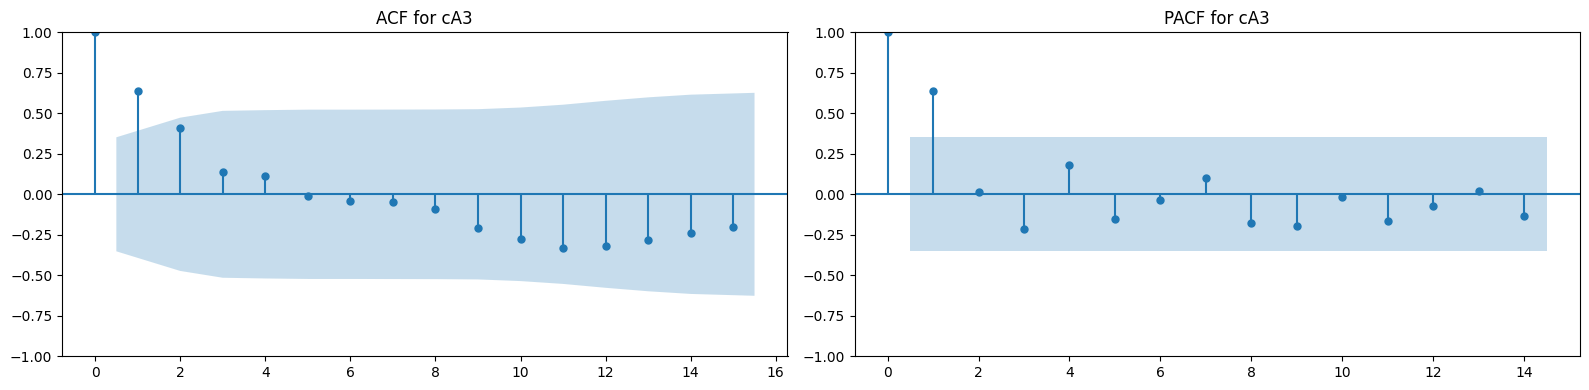

In [295]:
# Adjusting the number of lags for PACF
lags = len(cA3) // 2 - 1

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(cA3, ax=axes[0], title="ACF for cA3")

# Plot PACF with adjusted lags
plot_pacf(cA3, ax=axes[1], lags=lags, title="PACF for cA3")

plt.tight_layout()
plt.show()

Here's the interpretation of the results From the ACF and PACF plots for the cA3:

**cA3 coefficient series:**

The ACF shows a gradual decline, indicating that the series might have a moving average (MA) component.
The PACF has a sharp cutoff after the first lag, suggesting an autoregressive (AR) order of 1.
Based on the plots, an initial estimate for the ARIMA parameters for the cA3 coefficient series might be
`(p=1,d=0,q=1)` or `(p=1,d=0,q=0)`.

We can fit an ARIMA model with these parameters and evaluate its performance. We'll start with the `(p=1,d=0,q=1)` parameters for the cA3 series.

## Applying ARIMA with DWT

In [296]:
# Fit ARIMA model with parameters (p=1, d=0, q=1) on cA3 series
arima_cA3 = ARIMA(cA3, order=(1, 0, 1))
arima_cA3_fit = arima_cA3.fit()

# Display the model summary
arima_cA3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -244.911
Date:                Sun, 22 Oct 2023   AIC                            497.821
Time:                        18:42:55   BIC                            503.557
Sample:                             0   HQIC                           499.691
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1161.3864    472.127      2.460      0.014     236.034    2086.738
ar.L1          0.6188      0.256      2.418      0.016       0.117       1.120
ma.L1          0.1013      0.827      0.122      0.903      -1.519       1.722
sigma2      4.179e+05    6.2e+04      6.742      0.000    2.96e+05    5.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                39.91
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               5.11   Skew:                             1.02
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In Simple Approach lets we'll make the following assumptions based on the insights gathered from the ACF and PACF plots of
cA3:

1.   Use the ARIMA parameters (p=1,d=0,q=0) for all the coefficient series.
2.   Forecast each coefficient series for the year 2024.
3.   Use the inverse wavelet transform to reconstruct the forecasted DRC_cases for 2024.

Let's start by fitting ARIMA models with parameters
(p=1,d=0,q=0) for each coefficient series and then forecasting for 2024.

In [297]:
# Define a function to fit ARIMA and forecast for the given series
def fit_and_forecast(series, forecast_periods):
    model = ARIMA(series, order=(1, 0, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_periods)
    return forecast

# Number of forecast periods (for 2024)
forecast_periods = len(data['DRC_cases']) // 62

# Forecast each coefficient series
forecast_cA3 = fit_and_forecast(cA3, forecast_periods)
forecast_cD3 = fit_and_forecast(cD3, forecast_periods)
forecast_cD2 = fit_and_forecast(cD2, forecast_periods)
forecast_cD1 = fit_and_forecast(cD1, forecast_periods)

forecast_cA3, forecast_cD3, forecast_cD2, forecast_cD1

(array([400.20973876, 666.67360928, 844.08806829]),
 array([11.63849466,  7.13978079,  8.87870211]),
 array([16.1122401 , 12.09515537, 13.09669021]),
 array([-3.79844129, -3.46937755, -3.49788476]))

In [298]:
# Obtain in-sample predictions
predicted_cA3 = arima_cA3_fit.predict()

# Calculate MSE
mse_arima = mean_squared_error(cA3, predicted_cA3)
print(f"Mean Squared Error for ARIMA with DWT model: {mse_arima}")

Mean Squared Error for ARIMA with DWT model: 424740.8948466756


We have forecasted values for each coefficient series for the year 2024: cA3 forecast: Represents the coarse approximation.cD3,cD2,and cD1 forecasts: Represent details at different levels.
The next step is to use the inverse wavelet transform to reconstruct the forecasted DRC_cases for 2024 using these forecasts. Let's perform this reconstruction.

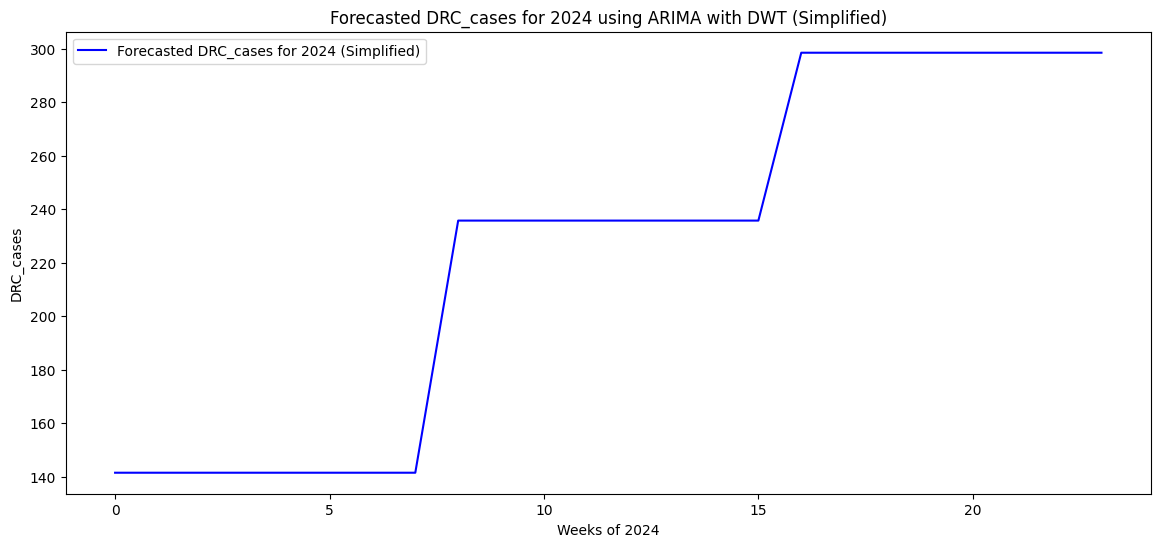

In [299]:
# Use inverse wavelet transform with only the approximation coefficients for reconstruction
reconstructed_forecast_simple = pywt.waverec([forecast_cA3, None, None, None], wavelet='db1')

# Plot the simplified reconstructed forecast
plt.figure(figsize=(14, 6))
plt.plot(reconstructed_forecast_simple, label='Forecasted DRC_cases for 2024 (Simplified)', color='blue')
plt.title('Forecasted DRC_cases for 2024 using ARIMA with DWT (Simplified)')
plt.legend()
plt.xlabel('Weeks of 2024')
plt.ylabel('DRC_cases')
plt.show()

In [300]:
def plot_arima(column,lab):
  # Extract the original T2M data from 2019 to 2023

  original_data = column
  reconstructed_forecast_simple = pywt.waverec([forecast_cA3, None, None, None], wavelet='db1')

  # Combine the original data with the forecasted values
  combined_data = np.concatenate((original_data, reconstructed_forecast_simple))

  # Calculate number of weeks in the original data (excluding forecast)
  num_weeks_original = len(original_data)

  # Create x-axis tick positions and labels to indicate weeks of each year
  years = list(range(2019, 2024+1))
  tick_positions = [i * 52 for i in range(len(years))]
  tick_labels = [str(year) for year in years]

  # Plot the combined data with adjusted x-axis
  plt.figure(figsize=(16, 7))
  plt.plot(combined_data, label=f'{lab} (2019-2023) with Forecast (2024)', color='blue')
  plt.axvline(x=num_weeks_original-1, color='red', linestyle='--', label='Start of 2024 Forecast')
  plt.xticks(tick_positions, tick_labels)
  plt.title(f'{lab} from 2019 to 2023 and Forecast for 2024 using ARIMA with DWT')
  plt.legend()
  plt.xlabel('Weeks of Each Year')
  plt.ylabel(lab)
  plt.tight_layout()
  plt.show()

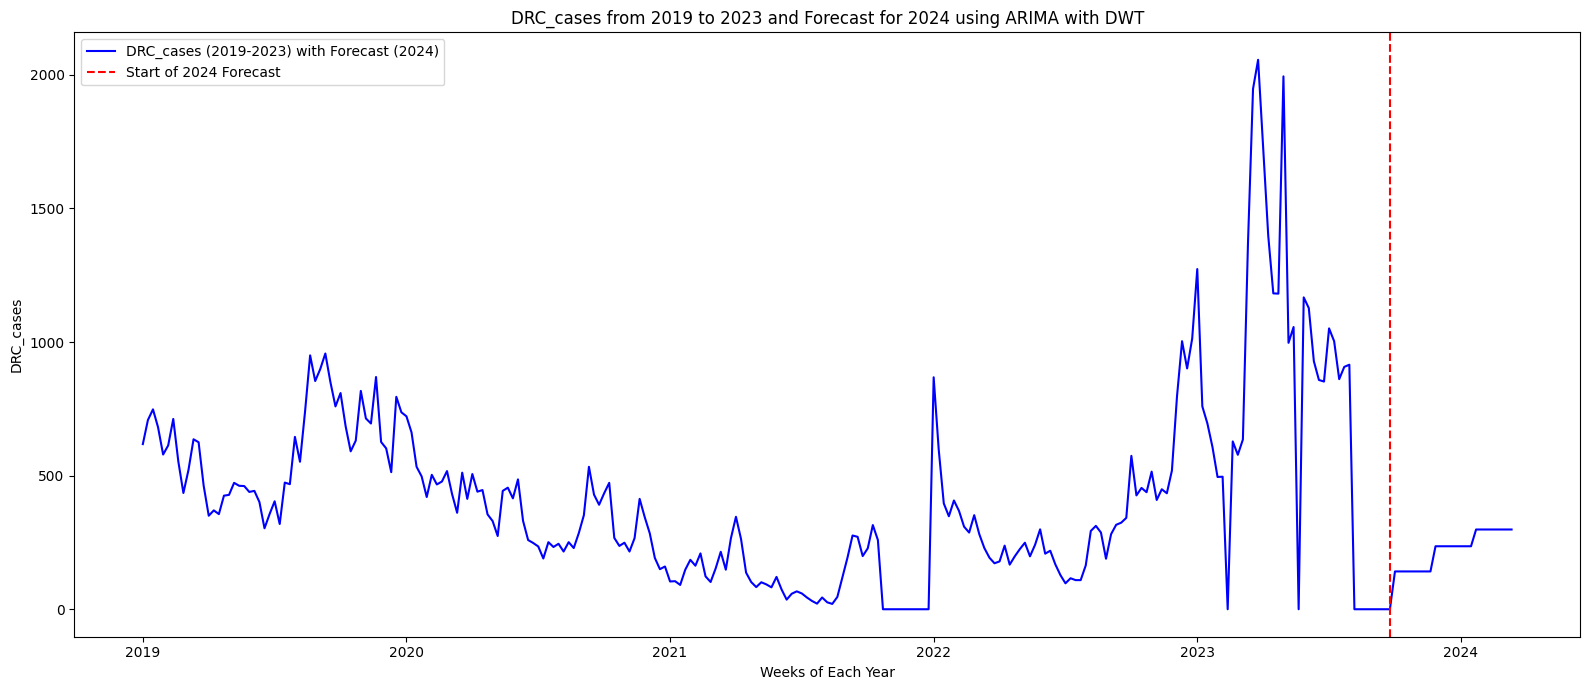

In [301]:
plot_arima(data['DRC_cases'],'DRC_cases')

## **Applying a Sarimax Model for DRC_Cases**

Augmented Dickey-Fuller test (ADF test) on the 'DRC_cases' time series data. This test is commonly used to determine whether a time series is stationary or not.

In [199]:
# Defining a Function for ADF test to check stationarity of the data
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

In [200]:
ad_test(data['DRC_cases'])

1. ADF :  -2.2182668721202505
2. P-Value :  0.19968255966575604
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression: 233
5. Critical Values :
	 1% :  -3.458731141928624
	 5% :  -2.8740258764297293
	 10% :  -2.5734243167124093


### Applying differencing to make series stationary

In [201]:
data['DRC_cases_diff'] = data['DRC_cases'].diff()
data.dropna(inplace=True)
result_diff = adfuller(data['DRC_cases_diff'])
adf_stat_diff, p_value_diff = result_diff[0], result_diff[1]

adf_stat_diff, p_value_diff

(-8.173875716539763, 8.479171332478793e-13)

In [202]:
# Lets try Sarimax also
sarimax_model_cases = SARIMAX(data['DRC_cases'],order=(1,1,1), seasonal_order =(1,1,1,52))
sarimax_fit_cases = sarimax_model_cases.fit()
sarimax_fit_cases.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          DRC_cases   No. Observations:                  247
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1323.747
Date:                            Sun, 22 Oct 2023   AIC                           2657.495
Time:                                    17:16:10   BIC                           2673.834
Sample:                                01-13-2019   HQIC                          2664.111
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6768      0.121     -5.600      0.000      -0.914      -0.440
ma.L1          0.5068      0.146      3.475      0.001       0.221       0.793
ar.S.L52      -0.1448      0.825     -0.176      0.861      -1.761       1.472
ma.S.L52      -0.1610      0.844     -0.191      0.849      -1.816       1.494
sigma2      4.841e+04   2513.831     19.256      0.000    4.35e+04    5.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               579.77
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               8.99   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [203]:
#Extract AIC and BIC from SARIMAX model
sarimax_aic_cases = sarimax_fit_cases.aic
sarimax_bic_cases = sarimax_fit_cases.bic

sarimax_aic_cases, sarimax_bic_cases

(2657.49493339068, 2673.834224185997)

In [204]:
#Generating SARIMAX Forecast
sarimax_forecast_cases =sarimax_fit_cases.get_forecast(steps=52)
sarimax_forecast_mean_cases = sarimax_forecast_cases.predicted_mean
sarimax_mse_cases = mean_squared_error(data['DRC_cases'].iloc[-52:], sarimax_forecast_mean_cases)

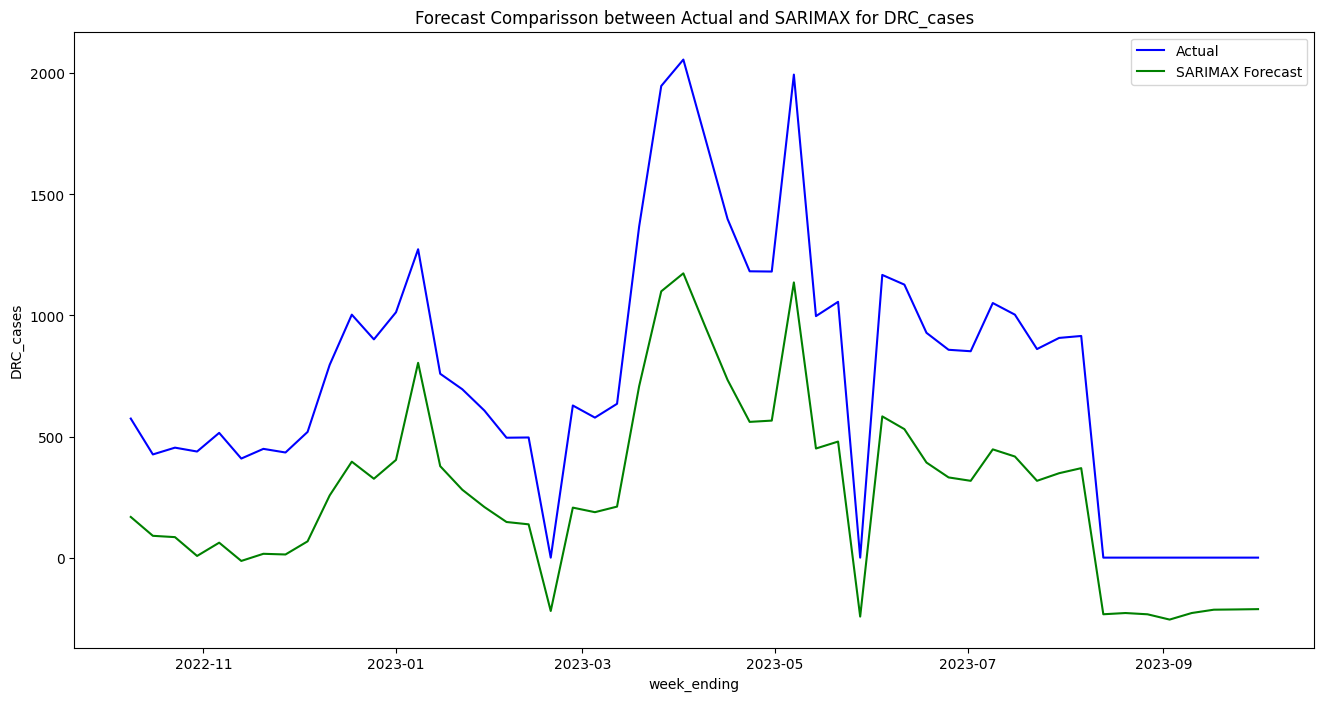

In [205]:
#Generate forecast using SARIMAX
sarimax_forecast =sarimax_fit_cases.get_forecast(steps=52)
sarimax_forecast_mean = sarimax_forecast.predicted_mean

# Calculating mean suqared error(MSE) for the forecasts

sarimax_mse = mean_squared_error(data['DRC_cases'].iloc[-52:], sarimax_forecast_mean)

#display the forecast metrics
plt.figure(figsize=(16, 8))

plt.plot(data['DRC_cases'].iloc[-52:], label='Actual',color='blue')
#plotting SARIMAX forecast
plt.plot(data.index[-52:],sarimax_forecast_mean, label='SARIMAX Forecast',color ='green')

plt.xlabel('week_ending')
plt.ylabel('DRC_cases')
plt.title('Forecast Comparisson between Actual and SARIMAX for DRC_cases')
plt.legend()
plt.show()

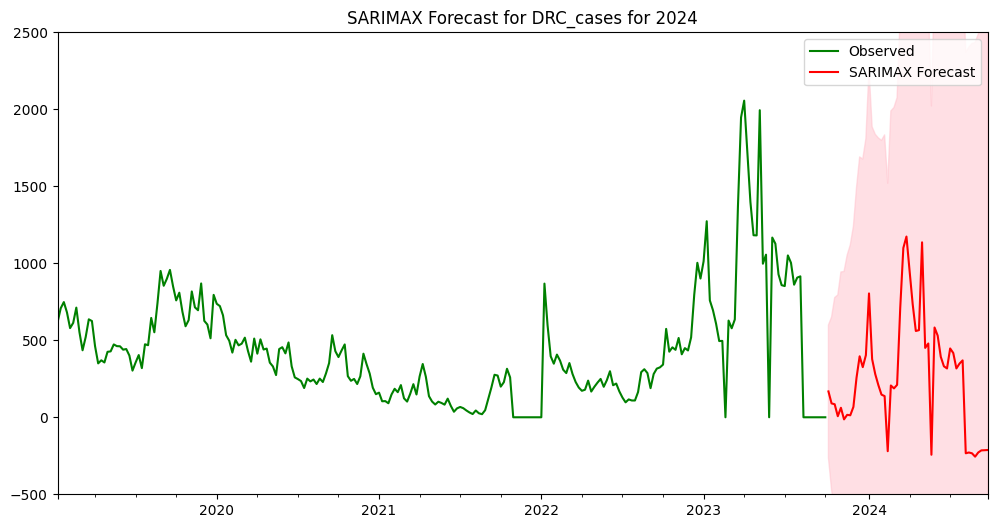

In [206]:
# Plot the forecasts and confidence intervals for 'sarimax_forecast'

fig, ax = plt.subplots(figsize=(12, 6))
data['DRC_cases'].plot(ax=ax, label='Observed',color='g')
sarimax_forecast_mean_cases.plot(ax=ax, label='SARIMAX Forecast', color='r')
ci_sarimax_cases = sarimax_forecast_cases.conf_int()
ax.fill_between(ci_sarimax_cases.index, ci_sarimax_cases.iloc[:, 0], ci_sarimax_cases.iloc[:, 1], color='pink',alpha=0.5)
ax.set_ylim(-500, 2500)
plt.title("SARIMAX Forecast for DRC_cases for 2024")
plt.legend()
plt.show()

In [207]:
# Display the MSE
print("SARIMAX Mean Squared Error (MSE):", sarimax_mse_cases)

SARIMAX Mean Squared Error (MSE): 253161.0250997894


### **Prophet Model for DRC_cases**

In [342]:
def prof(prophet_data):
  # Prepare the data for Prophet model


  # Initialize and train the Prophet model
  model_1 = Prophet()
  model_1.fit(prophet_data)

  # Predict for future (e.g., 365 days)
  future_1 = model_1.make_future_dataframe(periods=365)
  forecast_1 = model_1.predict(future_1)

  # Plotting
  fig_1 = model_1.plot(forecast_1)
  last_date = prophet_data['ds'].max()
  # Access the ax object and plot the observed data as a line
  ax = fig_1.gca()
  ax.plot(prophet_data['ds'], prophet_data['y'], 'pink', label='Observed data')

  # Highlight the forecast period with a vertical line
  last_date = prophet_data['ds'].max()
  ax.axvline(x=last_date, color='red', linestyle='--', label='End of historical data')

  plt.legend()
  plt.show()
  return forecast_1

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/bubhbipj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/7iqga8ai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21763', 'data', 'file=/tmp/tmp0po00pk2/bubhbipj.json', 'init=/tmp/tmp0po00pk2/7iqga8ai.json', 'output', 'file=/tmp/tmp0po00pk2/prophet_modelmvfi_wip/prophet_model-20231022190450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


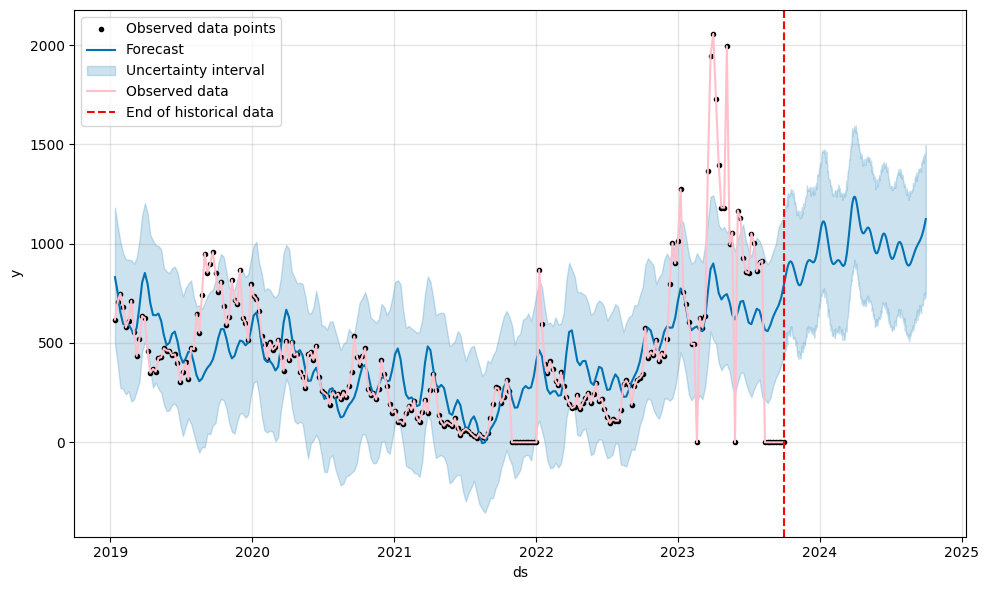

In [343]:
prophet_data = data.reset_index()
prophet_data.columns = ['ds', 'y', 'DRC_deaths', 'PRECTOTCORR', 'T2M', 'T2M_MAX', 'T2M_MIN','DRC_cases_diff']
prophet_data = prophet_data[['ds', 'y']]
# Prepare data for Prophet
pr=prof(prophet_data)

In [344]:
forecasted_values_1 = pr['yhat'][:len(prophet_data)]
actual_values_1 = prophet_data['y']

# Calculate MSE
mse_1 = mean_squared_error(actual_values_1, forecasted_values_1)
print(f"Mean Squared Error for Scenario 1: {mse_1}")

Mean Squared Error for Scenario 1: 75756.83650167898


### **Comparing the three models**

In [211]:
print(f"Mean Squared Error \nARIMA:   {mse_arima}\nSARIMAX: {sarimax_mse_cases}\nProphet: {mse_1}")

Mean Squared Error 
ARIMA:   405160.0707469235
SARIMAX: 253161.0250997894
Prophet: 76377.86723532055


**The best model out of the three seems to be Prophet as it has the best MSE score and it has fitted perfectly to our data**

# **Analysis On Death Variable**

## ARIMA with DWT

### Even though Prophet seems to be the best model, lets try all three models for each variable

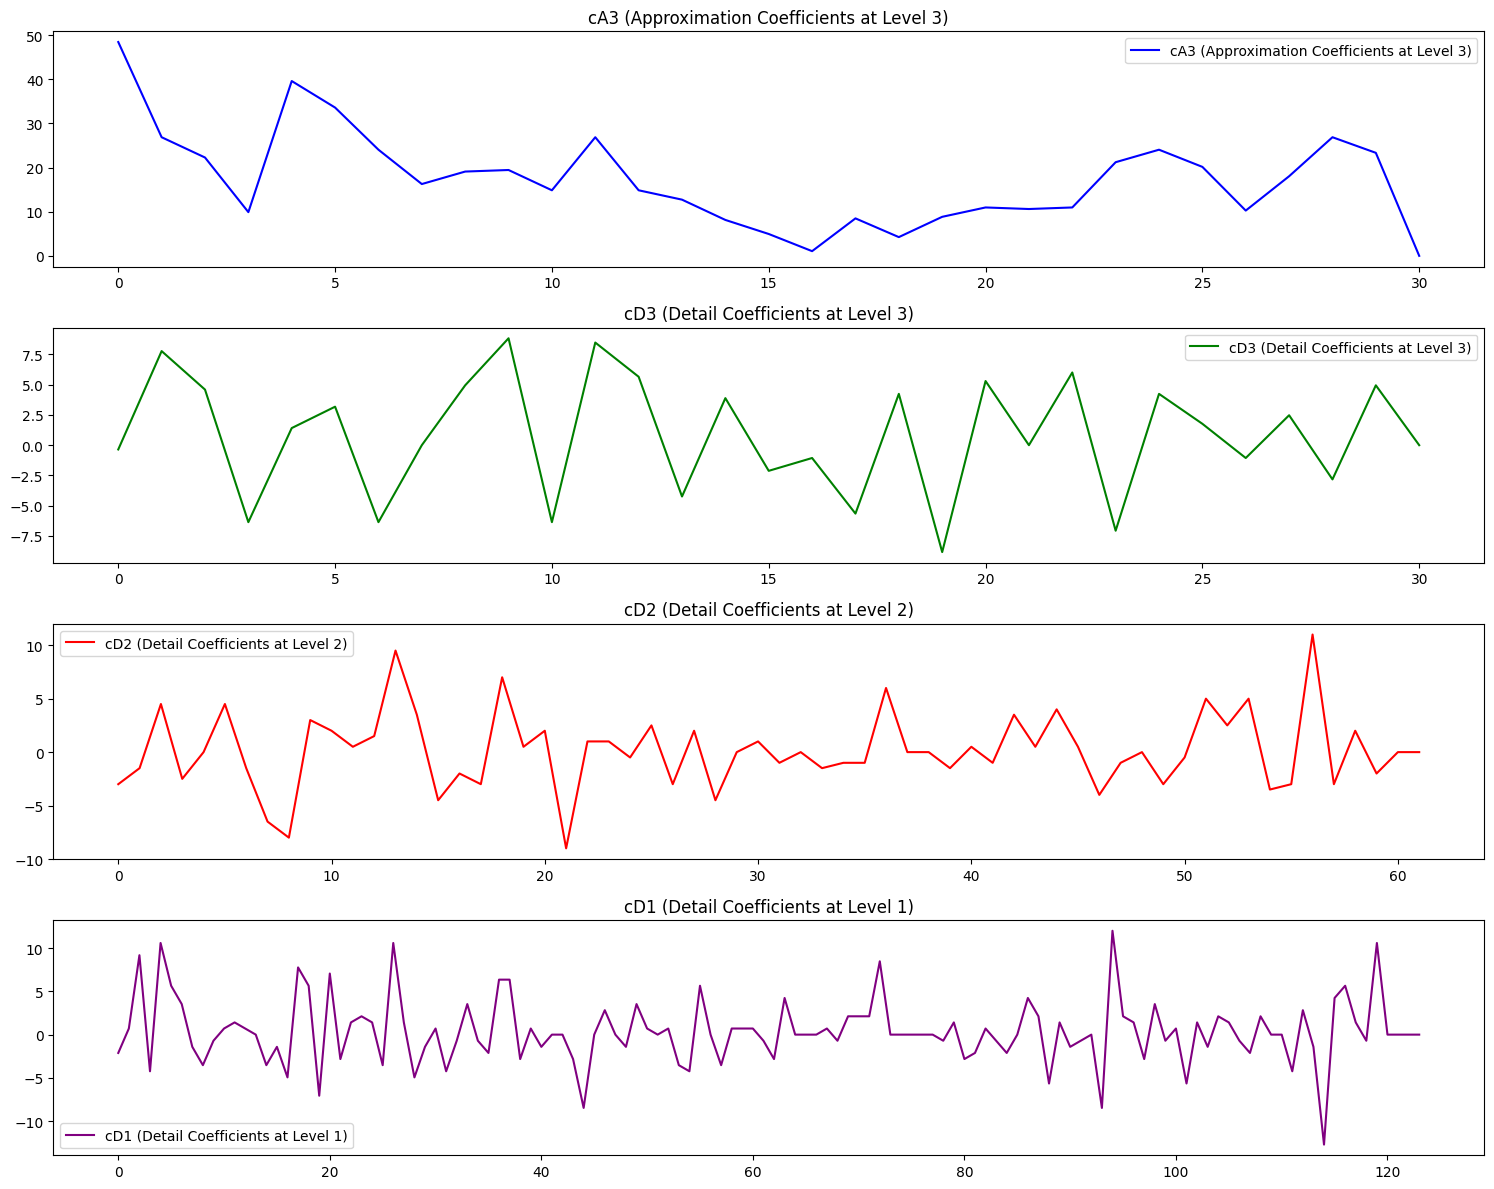

In [285]:
# Perform DWT on DRC_cases to decompose it
coeffs = pywt.wavedec(data['DRC_deaths'], wavelet='db1', level=3)
cA3, cD3, cD2, cD1 = coeffs

# Plot the coefficients
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(cA3, label="cA3 (Approximation Coefficients at Level 3)", color='blue')
axes[0].legend()
axes[0].set_title("cA3 (Approximation Coefficients at Level 3)")

axes[1].plot(cD3, label="cD3 (Detail Coefficients at Level 3)", color='green')
axes[1].legend()
axes[1].set_title("cD3 (Detail Coefficients at Level 3)")

axes[2].plot(cD2, label="cD2 (Detail Coefficients at Level 2)", color='red')
axes[2].legend()
axes[2].set_title("cD2 (Detail Coefficients at Level 2)")

axes[3].plot(cD1, label="cD1 (Detail Coefficients at Level 1)", color='purple')
axes[3].legend()
axes[3].set_title("cD1 (Detail Coefficients at Level 1)")

plt.tight_layout()
plt.show()

In [286]:
# Determine ARIMA parameters for cA3 series using auto_arima
arima_model_cA3 = auto_arima(cA3, seasonal=False, trace=True,
                             error_action='ignore', suppress_warnings=True,
                             stepwise=True)

# Display the best ARIMA parameters for cA3
arima_model_cA3.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=227.500, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=228.786, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=226.633, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=226.267, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.477 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -112.133
Date:                Sun, 22 Oct 2023   AIC                            226.267
Time:                        18:42:18   BIC                            227.668
Sample:                             0   HQIC                           226.715
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       103.3055     20.486      5.043      0.000      63.154     143.457
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 5.47
Prob(Q):                              0.45   Prob(JB):                         0.06
Heteroskedasticity (H):               0.53   Skew:                             0.53
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

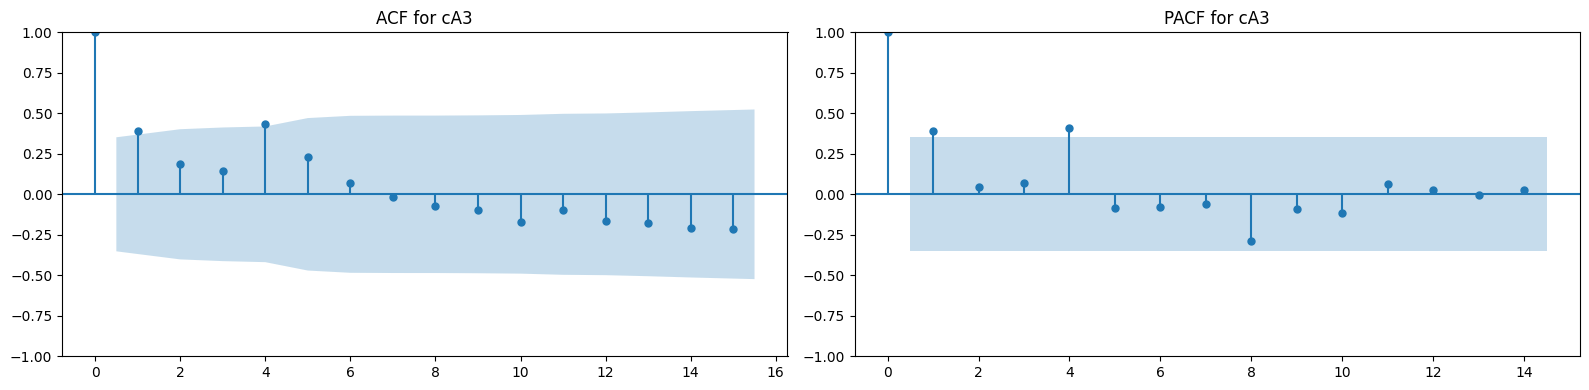

In [287]:
# Adjusting the number of lags for PACF
lags = len(cA3) // 2 - 1

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(cA3, ax=axes[0], title="ACF for cA3")

# Plot PACF with adjusted lags
plot_pacf(cA3, ax=axes[1], lags=lags, title="PACF for cA3")

plt.tight_layout()
plt.show()

In [288]:
# Fit ARIMA model with parameters (p=0, d=1, q=0) on cA3 series
arima_cA3 = ARIMA(cA3, order=(0, 1, 0))
arima_cA3_fit = arima_cA3.fit()

# Display the model summary
arima_cA3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -112.133
Date:                Sun, 22 Oct 2023   AIC                            226.267
Time:                        18:42:20   BIC                            227.668
Sample:                             0   HQIC                           226.715
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       103.3055     20.486      5.043      0.000      63.154     143.457
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 5.47
Prob(Q):                              0.45   Prob(JB):                         0.06
Heteroskedasticity (H):               0.53   Skew:                             0.53
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [289]:
# Number of forecast periods (for 2024)
forecast_periods = len(data['DRC_deaths']) // 62

# Forecast each coefficient series
forecast_cA3 = fit_and_forecast(cA3, forecast_periods)
forecast_cD3 = fit_and_forecast(cD3, forecast_periods)
forecast_cD2 = fit_and_forecast(cD2, forecast_periods)
forecast_cD1 = fit_and_forecast(cD1, forecast_periods)

forecast_cA3, forecast_cD3, forecast_cD2, forecast_cD1

(array([ 7.70853074, 12.1135307 , 14.63074511]),
 array([1.16988199, 0.70974129, 0.8907249 ]),
 array([0.17648374, 0.16400353, 0.16488608]),
 array([0.41849116, 0.36023665, 0.36834575]))

In [290]:
# Obtain in-sample predictions
predicted_cA3 = arima_cA3_fit.predict()

# Calculate MSE
mse_arima_deaths = mean_squared_error(cA3, predicted_cA3)
print(f"Mean Squared Error for ARIMA with DWT model: {mse_arima_deaths}")

Mean Squared Error for ARIMA with DWT model: 175.65322580645685


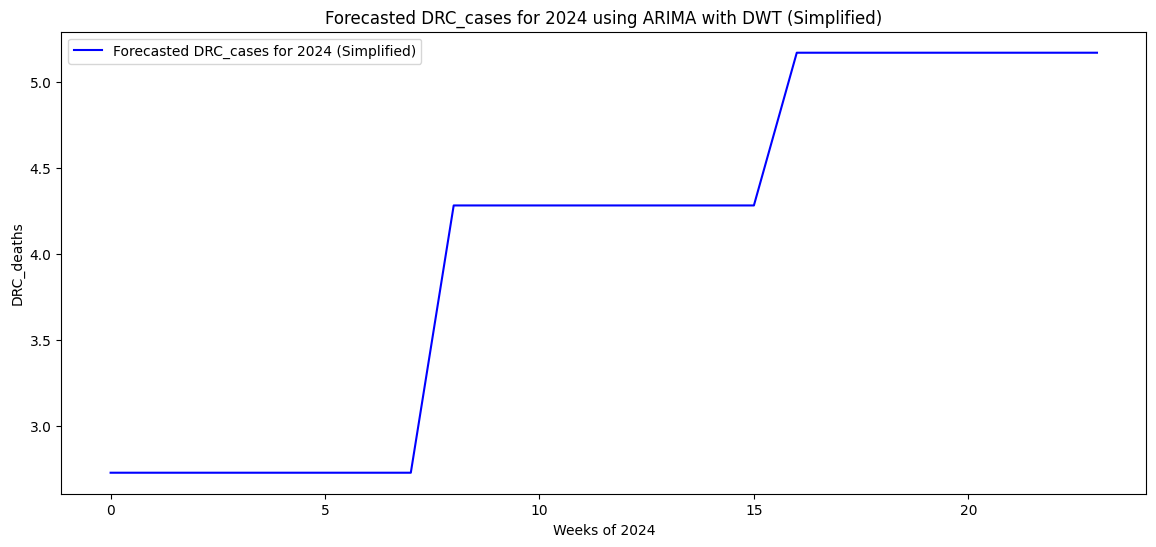

In [291]:
# Use inverse wavelet transform with only the approximation coefficients for reconstruction
reconstructed_forecast_simple = pywt.waverec([forecast_cA3, None, None, None], wavelet='db1')

# Plot the simplified reconstructed forecast
plt.figure(figsize=(14, 6))
plt.plot(reconstructed_forecast_simple, label='Forecasted DRC_cases for 2024 (Simplified)', color='blue')
plt.title('Forecasted DRC_cases for 2024 using ARIMA with DWT (Simplified)')
plt.legend()
plt.xlabel('Weeks of 2024')
plt.ylabel('DRC_deaths')
plt.show()

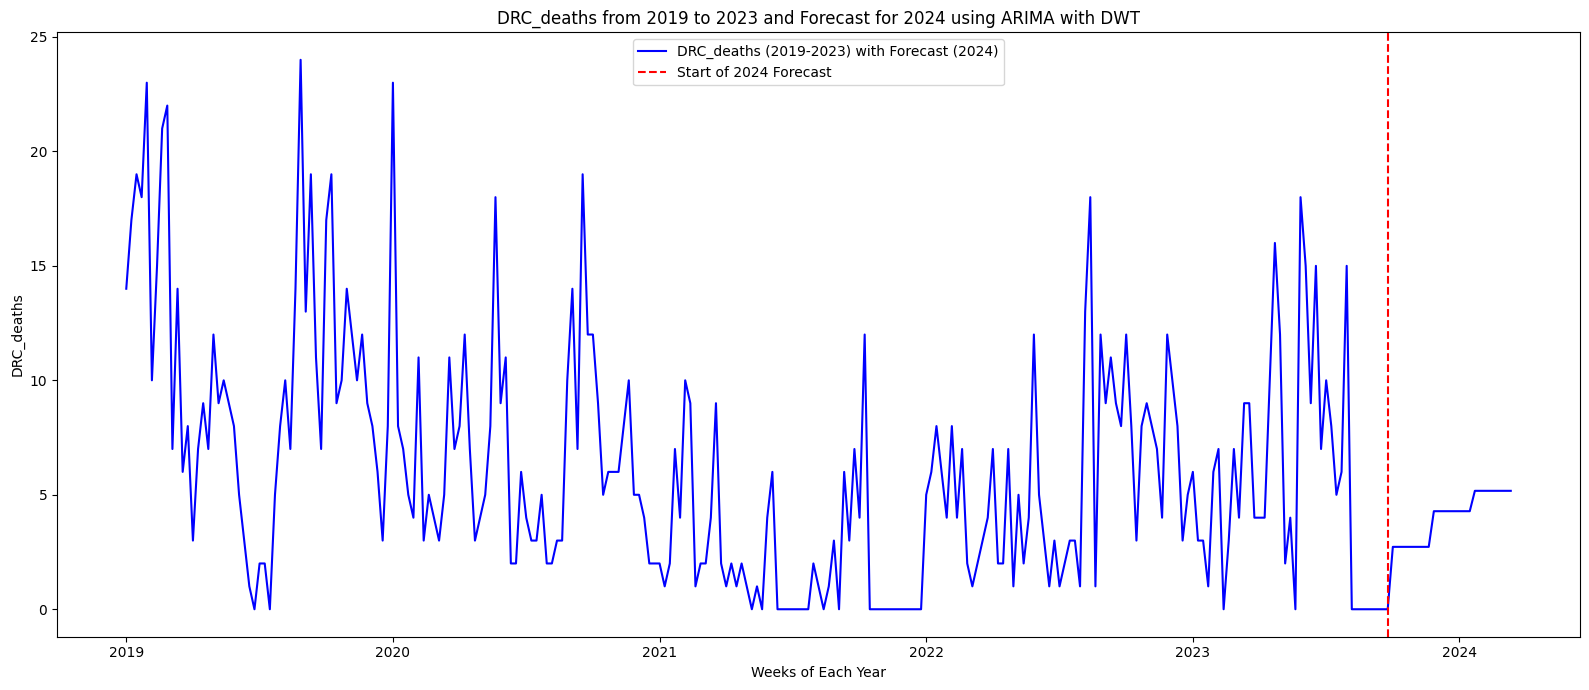

In [292]:
plot_arima(data['DRC_deaths'],'DRC_deaths')

## **SARIMAX model for DRC_deaths**

In [220]:
# Lets try Sarimax also
sarimax_model_deaths = SARIMAX(data['DRC_deaths'],order=(1,1,1), seasonal_order =(1,1,1,52))
sarimax_fit_deaths = sarimax_model_deaths.fit()
sarimax_fit_deaths.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         DRC_deaths   No. Observations:                  247
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -589.641
Date:                            Sun, 22 Oct 2023   AIC                           1189.283
Time:                                    17:29:25   BIC                           1205.622
Sample:                                01-13-2019   HQIC                          1195.899
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2216      0.110      2.017      0.044       0.006       0.437
ma.L1         -0.7988      0.076    -10.485      0.000      -0.948      -0.649
ar.S.L52      -0.3518      0.143     -2.464      0.014      -0.632      -0.072
ma.S.L52      -0.3587      0.170     -2.115      0.034      -0.691      -0.026
sigma2        22.2304      2.396      9.280      0.000      17.535      26.926
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.82   Prob(JB):                         0.51
Heteroskedasticity (H):               0.91   Skew:                             0.16
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [222]:
#Extract AIC and BIC from ARIMA & SARIMAX model
sarimax_aic_deaths = sarimax_fit_deaths.aic
sarimax_bic_deaths = sarimax_fit_deaths.bic

sarimax_aic_deaths, sarimax_bic_deaths

(1189.282621593143, 1205.6219123884596)

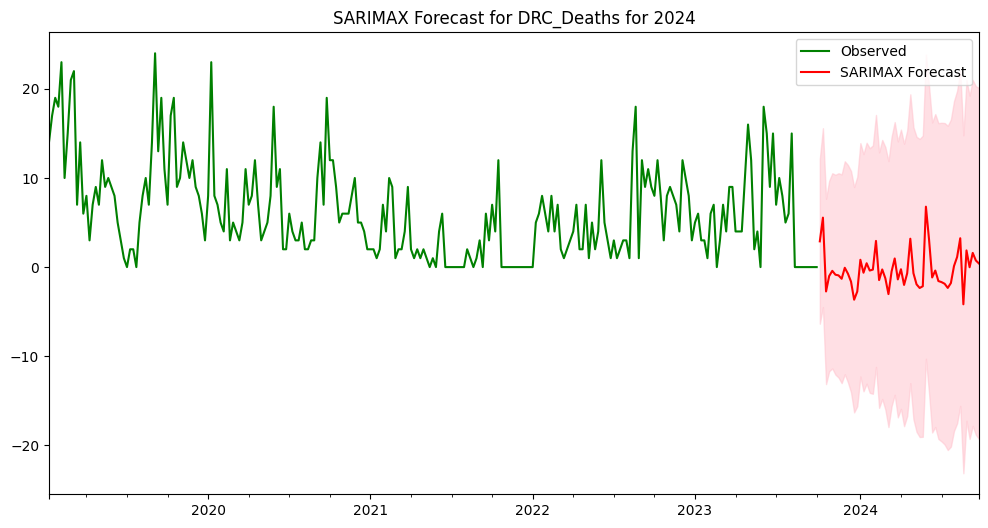

In [223]:
# Plot the forecasts and confidence intervals for 'sarimax_forecast'
sarimax_forecast_deaths =sarimax_fit_deaths.get_forecast(steps=52)
sarimax_forecast_mean_deaths = sarimax_forecast_deaths.predicted_mean

fig, ax = plt.subplots(figsize=(12, 6))
data['DRC_deaths'].plot(ax=ax, label='Observed',color='g')
sarimax_forecast_mean_deaths.plot(ax=ax, label='SARIMAX Forecast', color='r')
ci_sarimax_deaths = sarimax_forecast_deaths.conf_int()
ax.fill_between(ci_sarimax_deaths.index, ci_sarimax_deaths.iloc[:, 0], ci_sarimax_deaths.iloc[:, 1], color='pink',alpha=0.5)
plt.title("SARIMAX Forecast for DRC_Deaths for 2024")
plt.legend()
plt.show()

In [224]:
sarimax_mse_deaths = mean_squared_error(data['DRC_deaths'].iloc[-52:], sarimax_forecast_mean_deaths)
sarimax_mse_deaths

61.11982667898117

## **Prophet for DRC_deaths**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/ahhaf62x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/5mlxebar.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34163', 'data', 'file=/tmp/tmp0po00pk2/ahhaf62x.json', 'init=/tmp/tmp0po00pk2/5mlxebar.json', 'output', 'file=/tmp/tmp0po00pk2/prophet_modeli1cu4cvk/prophet_model-20231022190528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


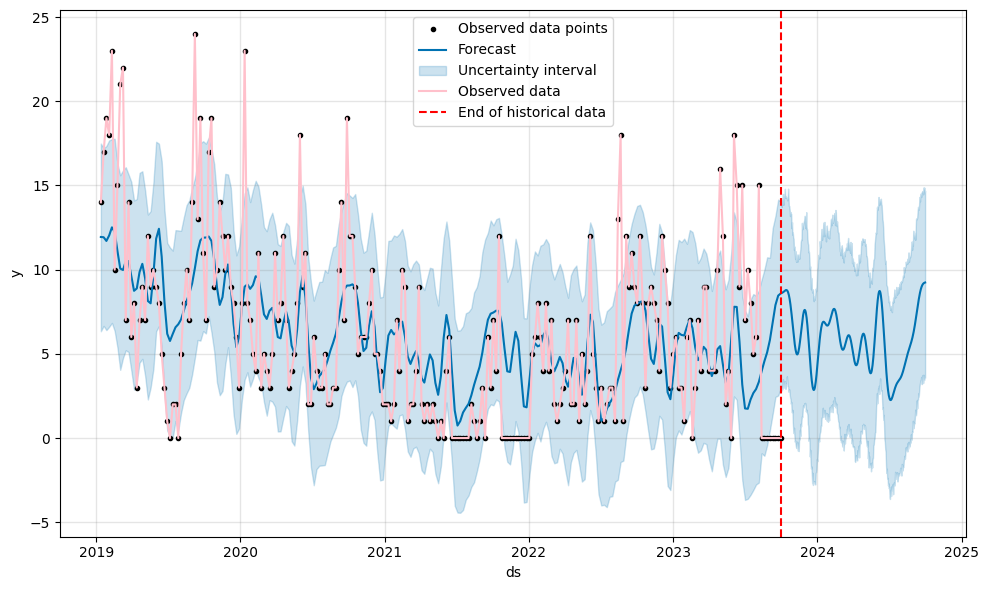

In [345]:
# Prepare the data for Prophet model
prophet_data = data.reset_index()
prophet_data.columns = ['ds', 'DRC_cases', 'y', 'PRECTOTCORR', 'T2M', 'T2M_MAX', 'T2M_MIN','DRC_cases_diff']
prophet_data = prophet_data[['ds', 'y']]
pr2=prof(prophet_data)

In [346]:
forecasted_values_1 = pr2['yhat'][:len(prophet_data)]
actual_values_1 = prophet_data['y']

# Calculate MSE
mse_2 = mean_squared_error(actual_values_1, forecasted_values_1)
print(f"Mean Squared Error for Scenario 1: {mse_2}")

Mean Squared Error for Scenario 1: 18.7878360501161


In [347]:
print(f"Mean Squared Error \nARIMA:   {mse_arima_deaths}\nSARIMAX: {sarimax_mse_deaths}\nProphet: {mse_2}")

Mean Squared Error 
ARIMA:   175.65322580645685
SARIMAX: 61.11982667898117
Prophet: 18.7878360501161


### **Again we can see that the best model out of the three is the Prophet model**

# **Analysis on PRECTOTCORR**

### **ARIMA with DWT on PRECTOTCORR**

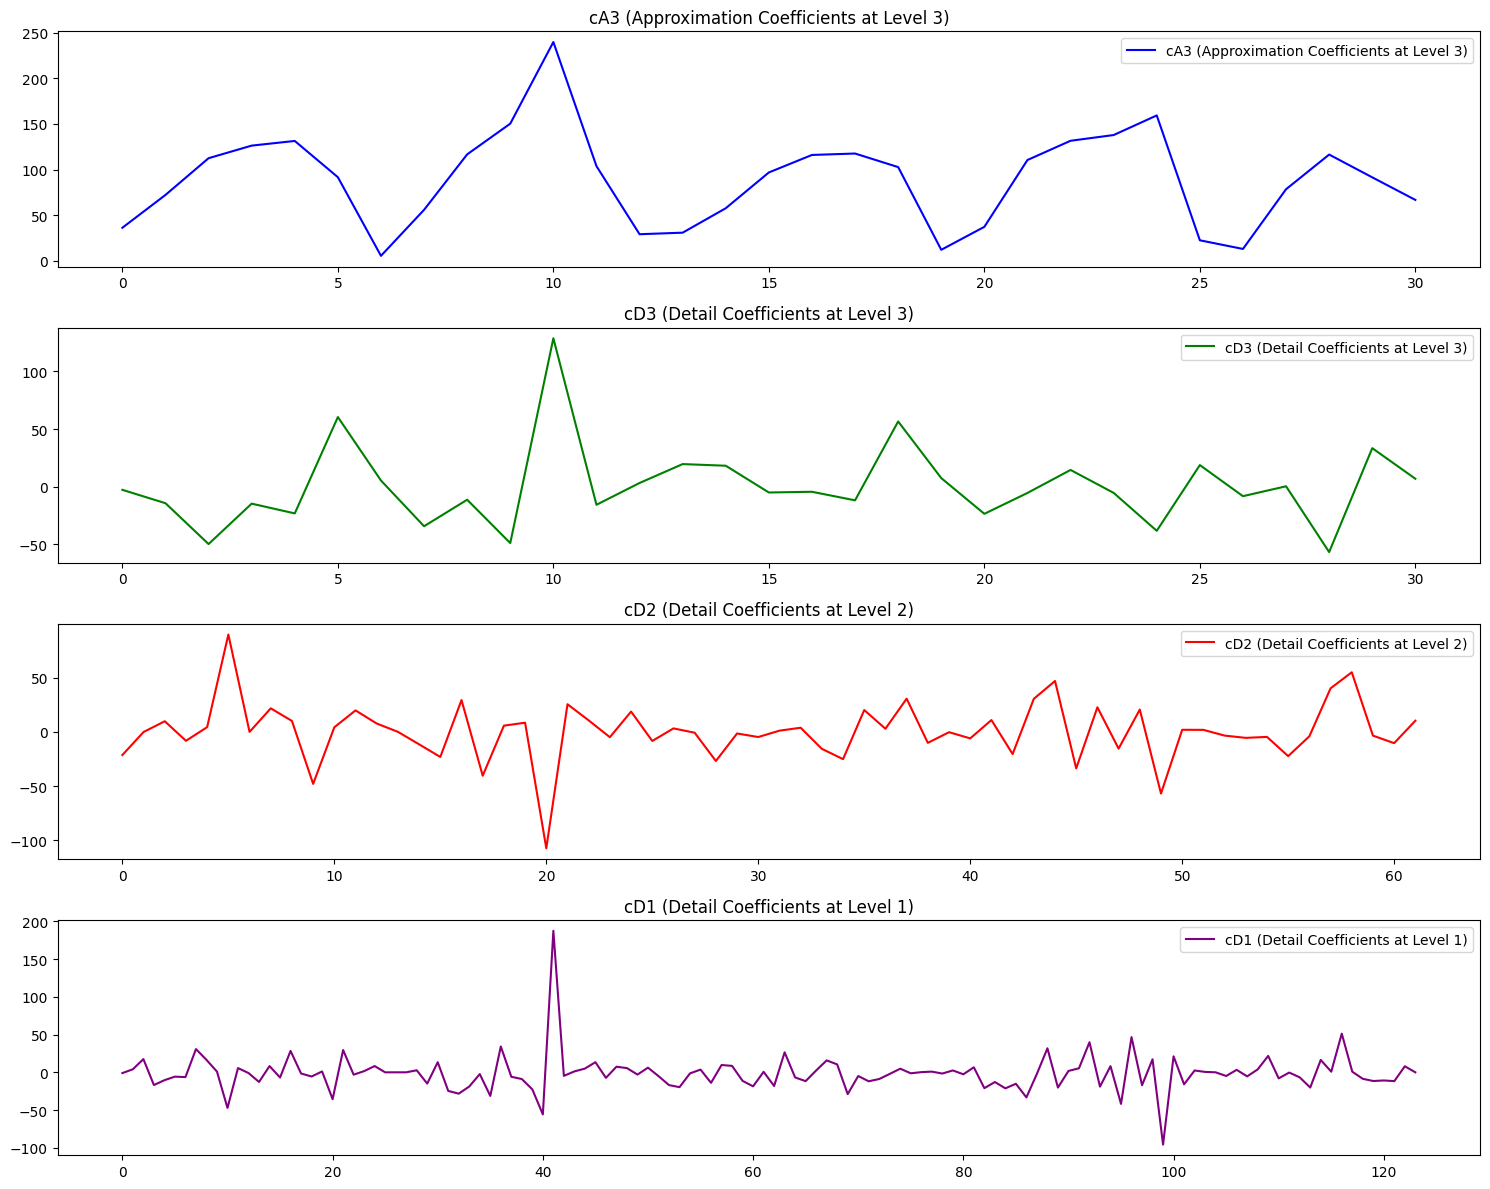

In [302]:
# Perform DWT on DRC_cases to decompose it
coeffs = pywt.wavedec(data['PRECTOTCORR'], wavelet='db1', level=3)
cA3, cD3, cD2, cD1 = coeffs

# Plot the coefficients
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(cA3, label="cA3 (Approximation Coefficients at Level 3)", color='blue')
axes[0].legend()
axes[0].set_title("cA3 (Approximation Coefficients at Level 3)")

axes[1].plot(cD3, label="cD3 (Detail Coefficients at Level 3)", color='green')
axes[1].legend()
axes[1].set_title("cD3 (Detail Coefficients at Level 3)")

axes[2].plot(cD2, label="cD2 (Detail Coefficients at Level 2)", color='red')
axes[2].legend()
axes[2].set_title("cD2 (Detail Coefficients at Level 2)")

axes[3].plot(cD1, label="cD1 (Detail Coefficients at Level 1)", color='purple')
axes[3].legend()
axes[3].set_title("cD1 (Detail Coefficients at Level 1)")

plt.tight_layout()
plt.show()

In [303]:
# Determine ARIMA parameters for cA3 series using auto_arima
arima_model_cA3 = auto_arima(cA3, seasonal=False, trace=True,
                             error_action='ignore', suppress_warnings=True,
                             stepwise=True)

# Display the best ARIMA parameters for cA3
arima_model_cA3.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=377.363, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=340.123, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=353.292, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=340.728, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=339.738, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=341.366, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=346.667, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=328.896, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=326.937, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=336.205, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=328.844, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=332.801, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -160.468
Date:                Sun, 22 Oct 2023   AIC                            326.937
Time:                        18:43:23   BIC                            331.239
Sample:                             0   HQIC                           328.339
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     88.3151     15.774      5.599      0.000      57.398     119.232
ma.L1          0.6439      0.212      3.036      0.002       0.228       1.060
sigma2      1803.7430    389.489      4.631      0.000    1040.359    2567.127
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.86   Prob(JB):                         0.49
Heteroskedasticity (H):               1.29   Skew:                            -0.11
Prob(H) (two-sided):                  0.69   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

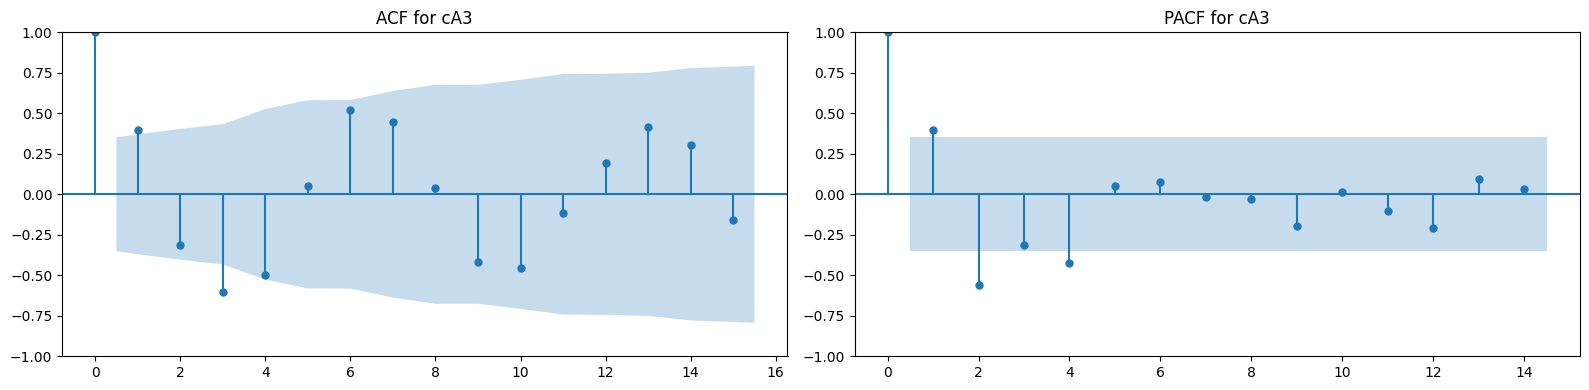

In [304]:
# Adjusting the number of lags for PACF
lags = len(cA3) // 2 - 1

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(cA3, ax=axes[0], title="ACF for cA3")

# Plot PACF with adjusted lags
plot_pacf(cA3, ax=axes[1], lags=lags, title="PACF for cA3")

plt.tight_layout()
plt.show()

In [305]:
# Fit ARIMA model with parameters (p=0, d=1, q=0) on cA3 series
arima_cA3 = ARIMA(cA3, order=(0, 1, 0))
arima_cA3_fit = arima_cA3.fit()

# Display the model summary
arima_cA3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -163.524
Date:                Sun, 22 Oct 2023   AIC                            329.048
Time:                        18:43:23   BIC                            330.449
Sample:                             0   HQIC                           329.496
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3177.4668    769.406      4.130      0.000    1669.459    4685.474
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 4.82
Prob(Q):                              0.49   Prob(JB):                         0.09
Heteroskedasticity (H):               1.17   Skew:                            -0.97
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [306]:
# Number of forecast periods (for 2024)
forecast_periods = len(data['PRECTOTCORR']) // 62

# Forecast each coefficient series
forecast_cA3 = fit_and_forecast(cA3, forecast_periods)
forecast_cD3 = fit_and_forecast(cD3, forecast_periods)
forecast_cD2 = fit_and_forecast(cD2, forecast_periods)
forecast_cD1 = fit_and_forecast(cD1, forecast_periods)

forecast_cA3, forecast_cD3, forecast_cD2, forecast_cD1

(array([79.32632018, 84.37760388, 86.40602558]),
 array([-1.52393611,  0.44558609, -0.00965719]),
 array([-1.24239348,  0.62534483,  0.32180089]),
 array([-1.71030964, -1.2920782 , -1.39435064]))

In [307]:
# Obtain in-sample predictions
predicted_cA3 = arima_cA3_fit.predict()

# Calculate MSE
mse_arima_PRECTOTCORR = mean_squared_error(cA3, predicted_cA3)
print(f"Mean Squared Error for ARIMA with DWT model: {mse_arima_PRECTOTCORR}")

Mean Squared Error for ARIMA with DWT model: 3116.9579116935497


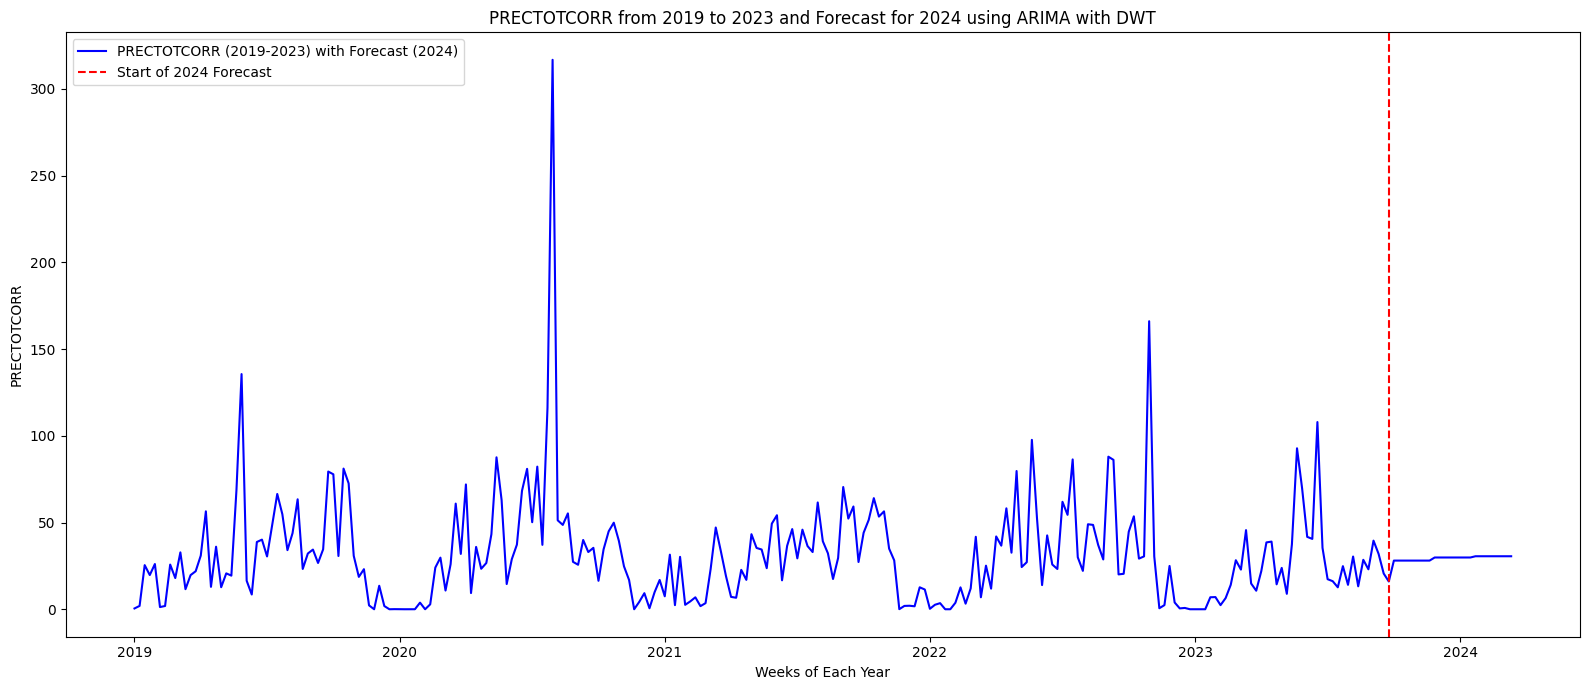

In [308]:
plot_arima(data['PRECTOTCORR'],'PRECTOTCORR')

## **SARIMAX for PRECTOTCORR**

In [240]:
# Lets try Sarimax also
sarimax_model_PRECTOTCORR = SARIMAX(data['PRECTOTCORR'],order=(1,1,1), seasonal_order =(1,1,1,52))
sarimax_fit_PRECTOTCORR = sarimax_model_PRECTOTCORR.fit()
sarimax_fit_PRECTOTCORR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        PRECTOTCORR   No. Observations:                  247
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -956.751
Date:                            Sun, 22 Oct 2023   AIC                           1923.502
Time:                                    17:49:55   BIC                           1939.841
Sample:                                01-13-2019   HQIC                          1930.118
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1940      0.067      2.904      0.004       0.063       0.325
ma.L1         -0.9995      1.526     -0.655      0.512      -3.990       1.991
ar.S.L52       0.0353      0.088      0.403      0.687      -0.137       0.207
ma.S.L52      -0.9988     53.902     -0.019      0.985    -106.645     104.647
sigma2       732.6236   3.93e+04      0.019      0.985   -7.63e+04    7.77e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1623.41
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             1.69
Prob(H) (two-sided):                  0.15   Kurtosis:                        16.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [241]:
#Extract AIC and BIC from ARIMA & SARIMAX model
sarimax_aic_PRECTOTCORR = sarimax_fit_PRECTOTCORR.aic
sarimax_bic_PRECTOTCORR = sarimax_fit_PRECTOTCORR.bic

sarimax_aic_PRECTOTCORR, sarimax_bic_PRECTOTCORR

(1923.5016792347456, 1939.8409700300622)

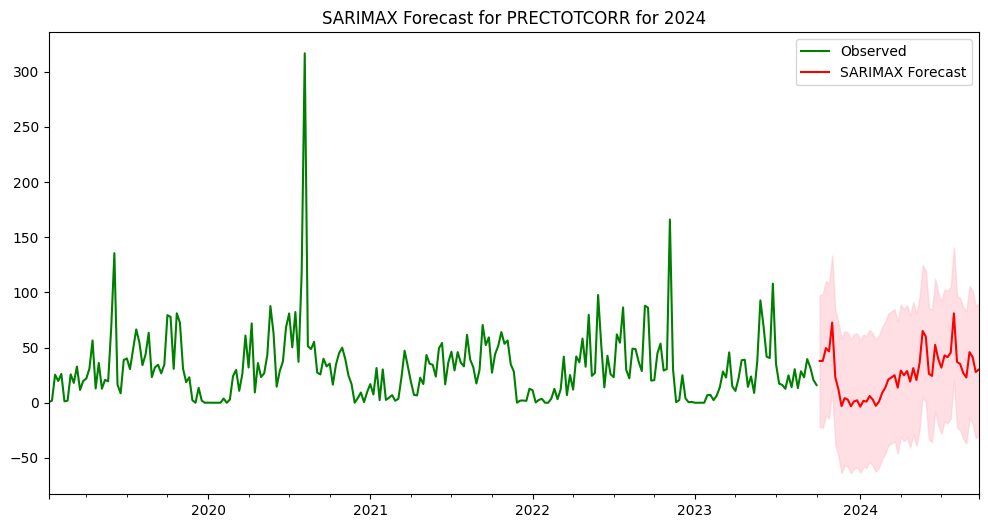

In [242]:
# Plot the forecasts and confidence intervals for 'sarimax_forecast'
sarimax_forecast_PRECTOTCORR =sarimax_fit_PRECTOTCORR.get_forecast(steps=52)
sarimax_forecast_mean_PRECTOTCORR = sarimax_forecast_PRECTOTCORR.predicted_mean

fig, ax = plt.subplots(figsize=(12, 6))
data['PRECTOTCORR'].plot(ax=ax, label='Observed',color='g')
sarimax_forecast_mean_PRECTOTCORR.plot(ax=ax, label='SARIMAX Forecast', color='r')
ci_sarimax_PRECTOTCORR = sarimax_forecast_PRECTOTCORR.conf_int()
ax.fill_between(ci_sarimax_PRECTOTCORR.index, ci_sarimax_PRECTOTCORR.iloc[:, 0], ci_sarimax_PRECTOTCORR.iloc[:, 1], color='pink',alpha=0.5)
plt.title("SARIMAX Forecast for PRECTOTCORR for 2024")
plt.legend()
plt.show()

In [243]:
PRECTOTCORR = mean_squared_error(data['PRECTOTCORR'].iloc[-52:], sarimax_forecast_mean_PRECTOTCORR)
PRECTOTCORR

459.59963492596484

## **Prophet on Prectotcorr**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/ttw2gn3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/ex0c0ban.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51672', 'data', 'file=/tmp/tmp0po00pk2/ttw2gn3v.json', 'init=/tmp/tmp0po00pk2/ex0c0ban.json', 'output', 'file=/tmp/tmp0po00pk2/prophet_modelymqw8xw9/prophet_model-20231022190614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


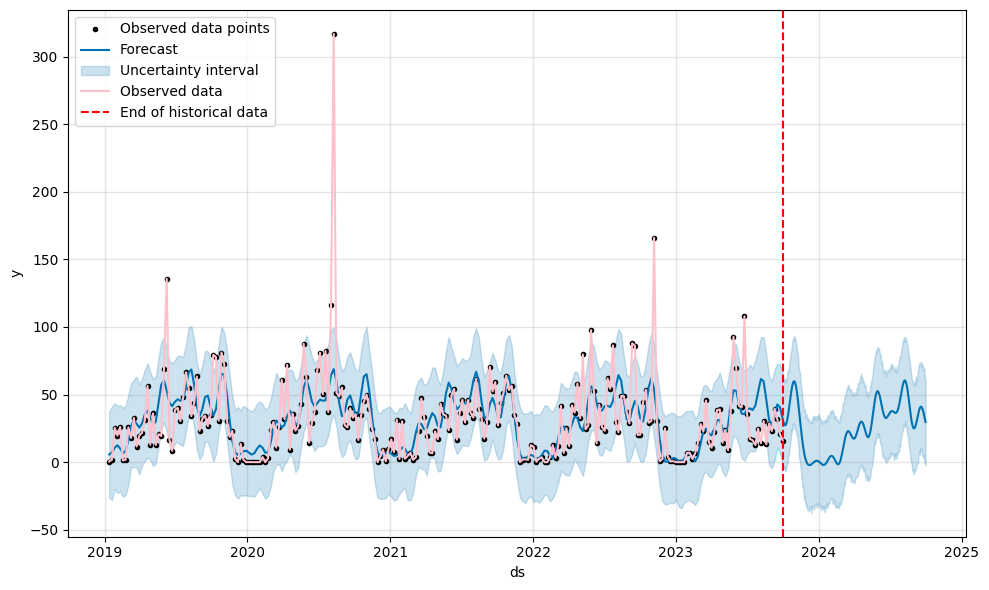

In [348]:
# Prepare the data for Prophet model
prophet_data = data.reset_index()
prophet_data.columns = ['ds', 'DRC_cases', 'DRC_deaths', 'y', 'T2M', 'T2M_MAX', 'T2M_MIN','DRC_cases_diff']
prophet_data = prophet_data[['ds', 'y']]
# Prepare data for Prophet
pr3=prof(prophet_data)

In [349]:
forecasted_values_1 = pr3['yhat'][:len(prophet_data)]
actual_values_1 = prophet_data['y']

# Calculate MSE
mse_3 = mean_squared_error(actual_values_1, forecasted_values_1)
print(f"Mean Squared Error for Scenario 1: {mse_3}")

Mean Squared Error for Scenario 1: 645.5526483411892


In [350]:
print(f"Mean Squared Error \nARIMA:   {mse_arima_PRECTOTCORR}\nSARIMAX: {PRECTOTCORR}\nProphet: {mse_3}")

Mean Squared Error 
ARIMA:   3116.9579116935497
SARIMAX: 459.59963492596484
Prophet: 645.5526483411892


### **Surprisingly in this case SARIMAX works better than prophet**

# **Analysis on T2M**

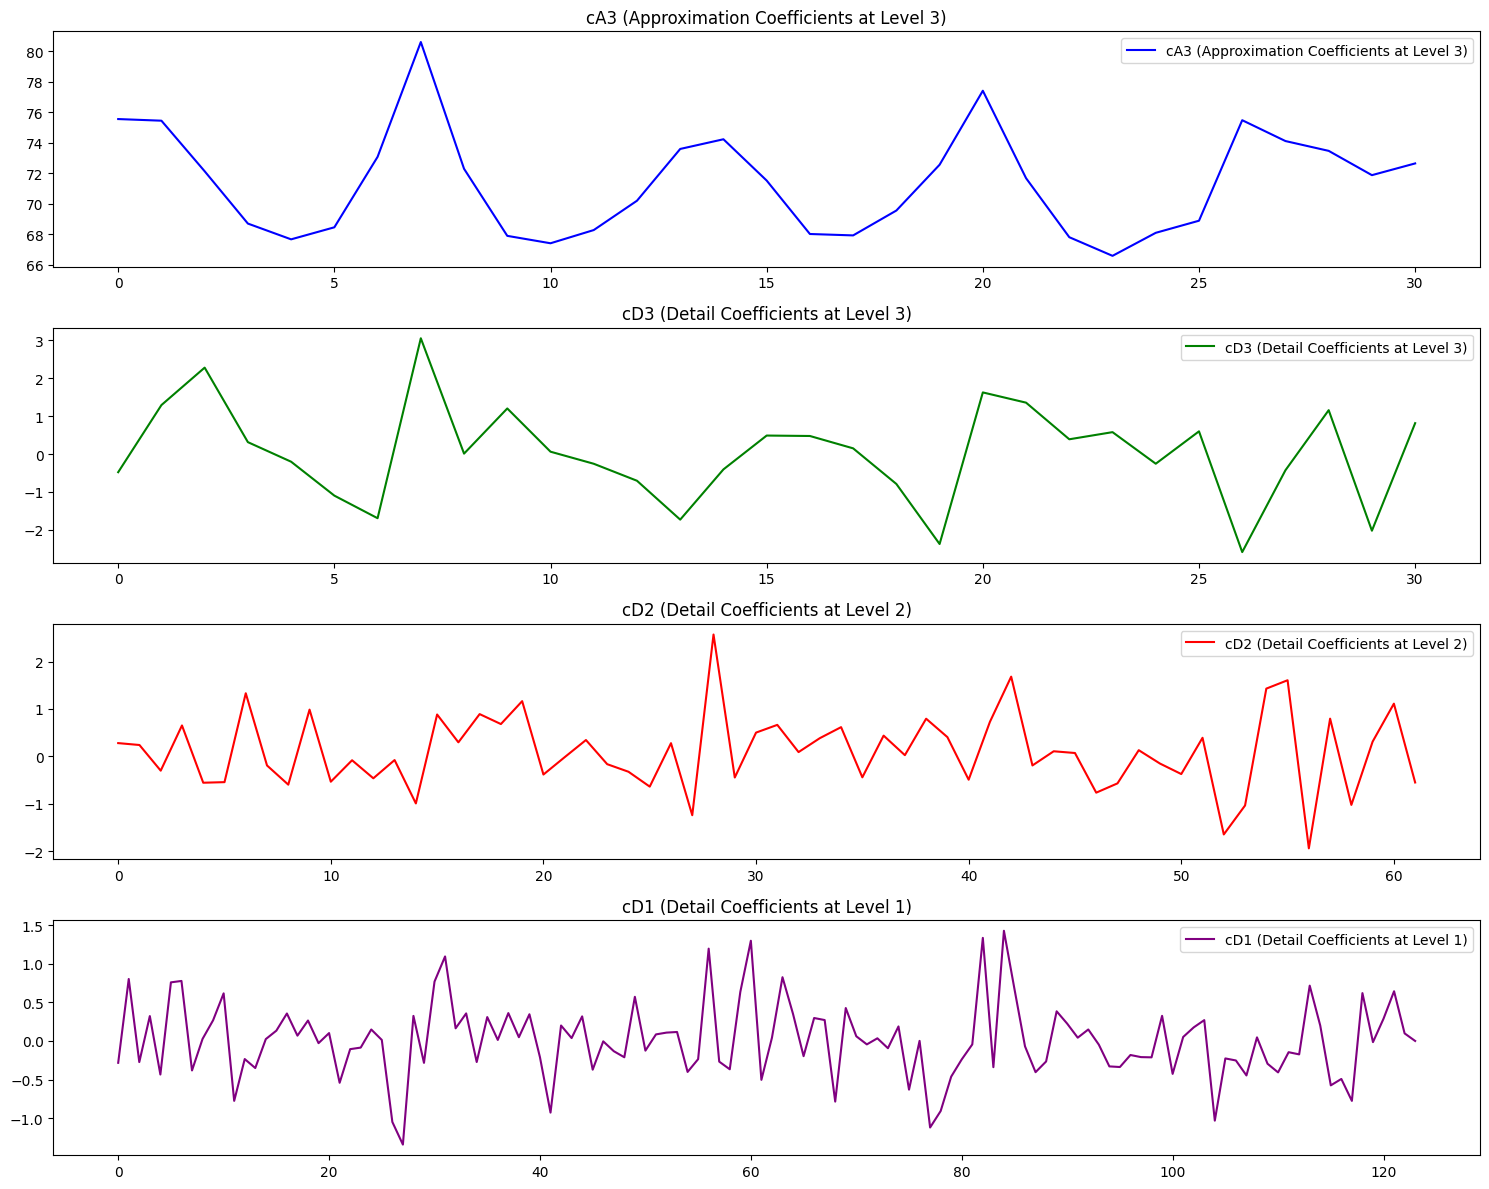

In [309]:
# Perform DWT on DRC_cases to decompose it
coeffs = pywt.wavedec(data['T2M'], wavelet='db1', level=3)
cA3, cD3, cD2, cD1 = coeffs

# Plot the coefficients
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(cA3, label="cA3 (Approximation Coefficients at Level 3)", color='blue')
axes[0].legend()
axes[0].set_title("cA3 (Approximation Coefficients at Level 3)")

axes[1].plot(cD3, label="cD3 (Detail Coefficients at Level 3)", color='green')
axes[1].legend()
axes[1].set_title("cD3 (Detail Coefficients at Level 3)")

axes[2].plot(cD2, label="cD2 (Detail Coefficients at Level 2)", color='red')
axes[2].legend()
axes[2].set_title("cD2 (Detail Coefficients at Level 2)")

axes[3].plot(cD1, label="cD1 (Detail Coefficients at Level 1)", color='purple')
axes[3].legend()
axes[3].set_title("cD1 (Detail Coefficients at Level 1)")

plt.tight_layout()
plt.show()


In [310]:
# Determine ARIMA parameters for cA3 series using auto_arima
arima_model_cA3 = auto_arima(cA3, seasonal=False, trace=True,
                             error_action='ignore', suppress_warnings=True,
                             stepwise=True)

# Display the best ARIMA parameters for cA3
arima_model_cA3.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=179.480, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=354.682, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=175.936, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=293.156, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=158.729, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=157.536, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=167.339, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=157.268, Time=0.04 sec
 ARIMA(1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 -74.634
Date:                Sun, 22 Oct 2023   AIC                            157.268
Time:                        18:44:40   BIC                            163.004
Sample:                             0   HQIC                           159.138
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     71.5099      1.374     52.027      0.000      68.816      74.204
ma.L1          0.8129      0.188      4.328      0.000       0.445       1.181
ma.L2          0.3012      0.236      1.277      0.201      -0.161       0.763
sigma2         7.0647      2.006      3.522      0.000       3.133      10.996
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.39
Prob(Q):                              0.83   Prob(JB):                         0.30
Heteroskedasticity (H):               0.52   Skew:                             0.62
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

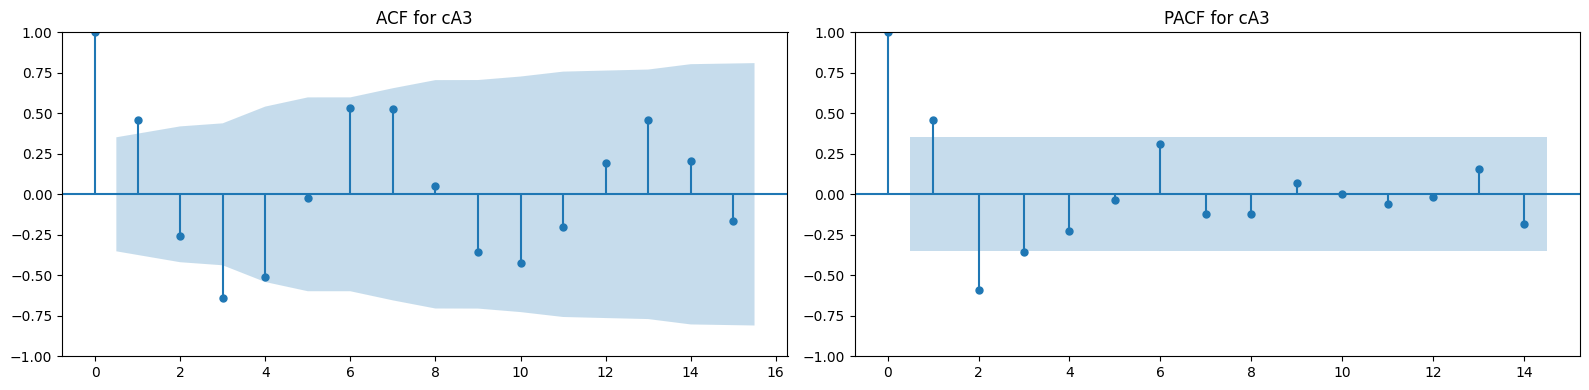

In [311]:
# Adjusting the number of lags for PACF
lags = len(cA3) // 2 - 1

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(cA3, ax=axes[0], title="ACF for cA3")

# Plot PACF with adjusted lags
plot_pacf(cA3, ax=axes[1], lags=lags, title="PACF for cA3")

plt.tight_layout()
plt.show()

In [312]:
# Fit ARIMA model with parameters (p=0, d=1, q=0) on cA3 series
arima_cA3 = ARIMA(cA3, order=(0, 1, 0))
arima_cA3_fit = arima_cA3.fit()

# Display the model summary
arima_cA3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -79.988
Date:                Sun, 22 Oct 2023   AIC                            161.976
Time:                        18:44:41   BIC                            163.377
Sample:                             0   HQIC                           162.424
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        12.1176      3.116      3.889      0.000       6.010      18.225
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.33   Prob(JB):                         0.99
Heteroskedasticity (H):               0.53   Skew:                             0.05
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [313]:
# Number of forecast periods (for 2024)
forecast_periods = len(data['T2M']) // 62

# Forecast each coefficient series
forecast_cA3 = fit_and_forecast(cA3, forecast_periods)
forecast_cD3 = fit_and_forecast(cD3, forecast_periods)
forecast_cD2 = fit_and_forecast(cD2, forecast_periods)
forecast_cD1 = fit_and_forecast(cD1, forecast_periods)

forecast_cA3, forecast_cD3, forecast_cD2, forecast_cD1

(array([72.06916884, 71.79350768, 71.66429064]),
 array([-0.0075107 ,  0.02737199,  0.02589296]),
 array([0.26102943, 0.06175348, 0.11071706]),
 array([0.00590851, 0.00629396, 0.00631911]))

In [314]:
# Obtain in-sample predictions
predicted_cA3 = arima_cA3_fit.predict()

# Calculate MSE
mse_arima_T2M = mean_squared_error(cA3, predicted_cA3)
print(f"Mean Squared Error for ARIMA with DWT model: {mse_arima_T2M}")

Mean Squared Error for ARIMA with DWT model: 195.92977752892176


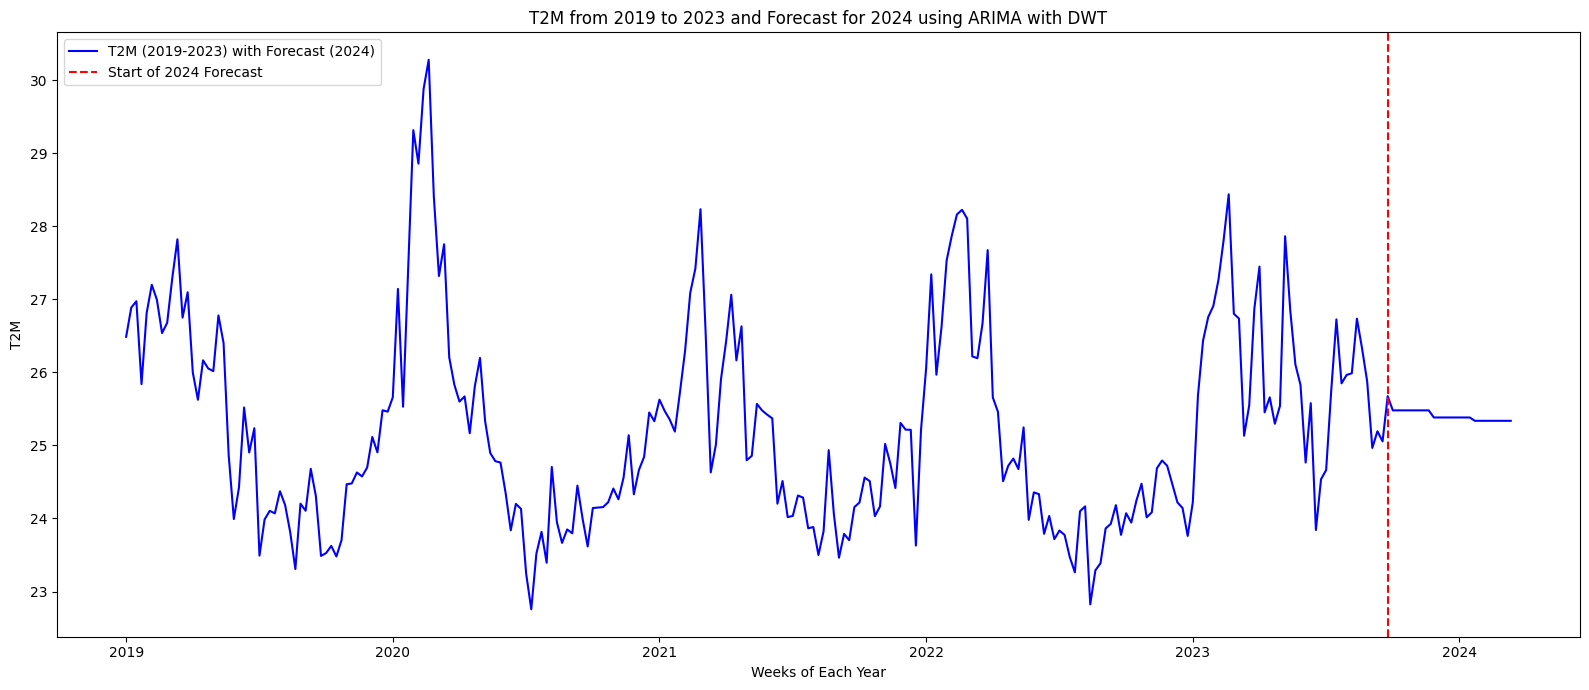

In [315]:
plot_arima(data['T2M'],'T2M')

## **SARIMAX for T2M**

In [254]:
# Lets try Sarimax also
sarimax_model_T2M = SARIMAX(data['T2M'],order=(1,1,1), seasonal_order =(1,1,1,52))
sarimax_fit_T2M = sarimax_model_T2M.fit()
sarimax_fit_T2M.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                T2M   No. Observations:                  247
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -231.440
Date:                            Sun, 22 Oct 2023   AIC                            472.879
Time:                                    18:09:35   BIC                            489.218
Sample:                                01-13-2019   HQIC                           479.495
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4916      0.090      5.462      0.000       0.315       0.668
ma.L1         -0.9039      0.049    -18.585      0.000      -0.999      -0.809
ar.S.L52      -0.1566      0.146     -1.072      0.284      -0.443       0.130
ma.S.L52      -0.7201      0.293     -2.454      0.014      -1.295      -0.145
sigma2         0.4964      0.102      4.855      0.000       0.296       0.697
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 3.82
Prob(Q):                              0.63   Prob(JB):                         0.15
Heteroskedasticity (H):               0.99   Skew:                             0.07
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [255]:
#Extract AIC and BIC from ARIMA & SARIMAX model
sarimax_aic_T2M = sarimax_fit_T2M.aic
sarimax_bic_T2M = sarimax_fit_T2M.bic

sarimax_aic_T2M, sarimax_bic_T2M

(472.87903884571347, 489.2183296410301)

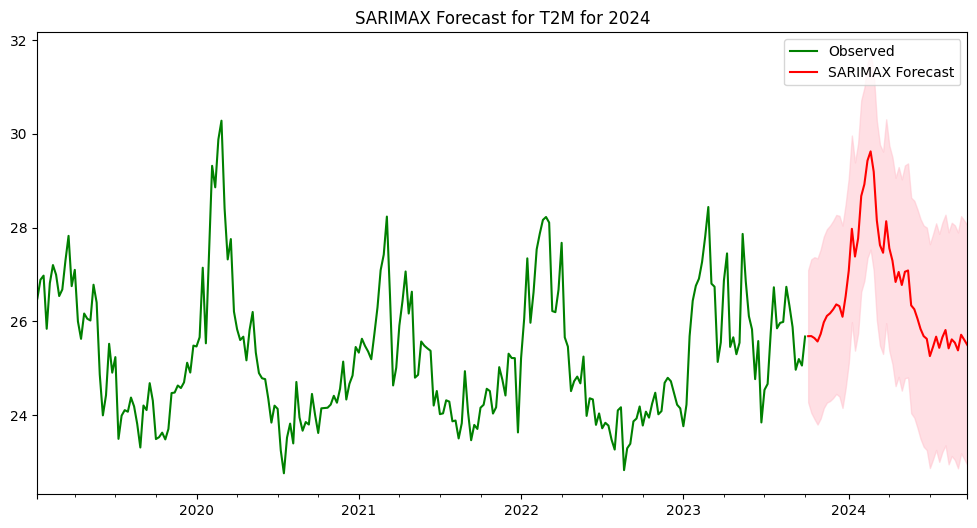

In [256]:
# Plot the forecasts and confidence intervals for 'sarimax_forecast'
sarimax_forecast_T2M =sarimax_fit_T2M.get_forecast(steps=52)
sarimax_forecast_mean_T2M = sarimax_forecast_T2M.predicted_mean

fig, ax = plt.subplots(figsize=(12, 6))
data['T2M'].plot(ax=ax, label='Observed',color='g')
sarimax_forecast_mean_T2M.plot(ax=ax, label='SARIMAX Forecast', color='r')
ci_sarimax_T2M = sarimax_forecast_T2M.conf_int()
ax.fill_between(ci_sarimax_T2M.index, ci_sarimax_T2M.iloc[:, 0], ci_sarimax_T2M.iloc[:, 1], color='pink',alpha=0.5)
plt.title("SARIMAX Forecast for T2M for 2024")
plt.legend()
plt.show()

In [257]:
SARIMAX_T2M_MSE = mean_squared_error(data['T2M'].iloc[-52:], sarimax_forecast_mean_T2M)
SARIMAX_T2M_MSE

2.0587896744663663

## **Prophet for T2M**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/sbueg51q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/4qvvclje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3051', 'data', 'file=/tmp/tmp0po00pk2/sbueg51q.json', 'init=/tmp/tmp0po00pk2/4qvvclje.json', 'output', 'file=/tmp/tmp0po00pk2/prophet_modelw1id1suo/prophet_model-20231022190701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


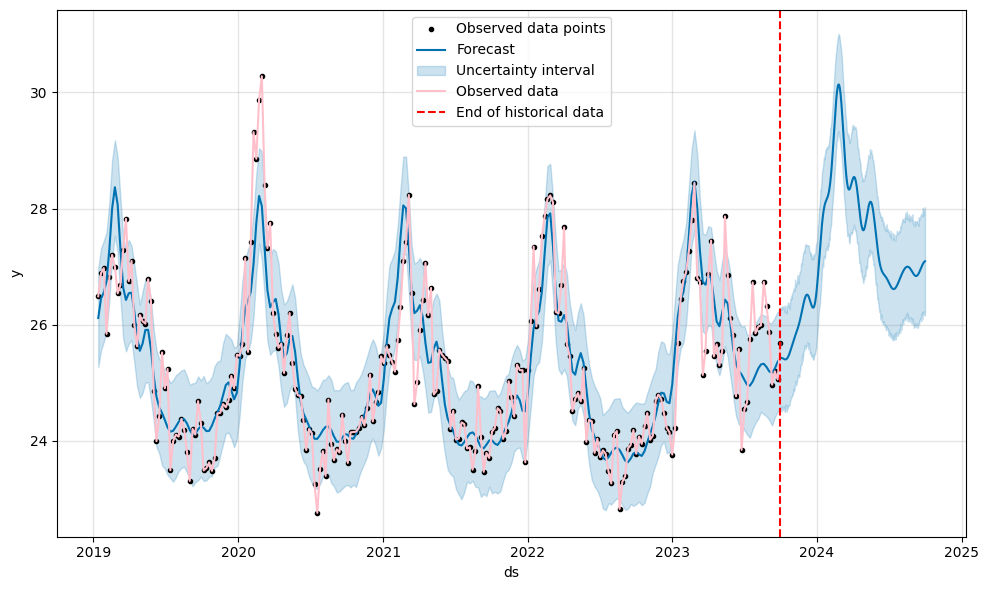

In [351]:
# Prepare the data for Prophet model
prophet_data = data.reset_index()
prophet_data.columns = ['ds', 'DRC_cases', 'DRC_deaths', 'PRECTOTCORR', 'y', 'T2M_MAX', 'T2M_MIN','DRC_cases_diff']
prophet_data = prophet_data[['ds', 'y']]
# Prepare data for Prophet

pr4=prof(prophet_data)

In [352]:
forecasted_values_1 = pr4['yhat'][:len(prophet_data)]
actual_values_1 = prophet_data['y']

# Calculate MSE
mse_4 = mean_squared_error(actual_values_1, forecasted_values_1)
print(f"Mean Squared Error for Scenario 1: {mse_4}")

Mean Squared Error for Scenario 1: 0.4504344637659824


In [353]:
print(f"Mean Squared Error \nARIMA:   {mse_arima_T2M}\nSARIMAX: {SARIMAX_T2M_MSE}\nProphet: {mse_4}")

Mean Squared Error 
ARIMA:   195.92977752892176
SARIMAX: 2.0587896744663663
Prophet: 0.4504344637659824


### **Again the best model here seems to be Prophet**

# **Analysis on T2M_MAX**

## **ARIMA with DWT on T2M_MAX**

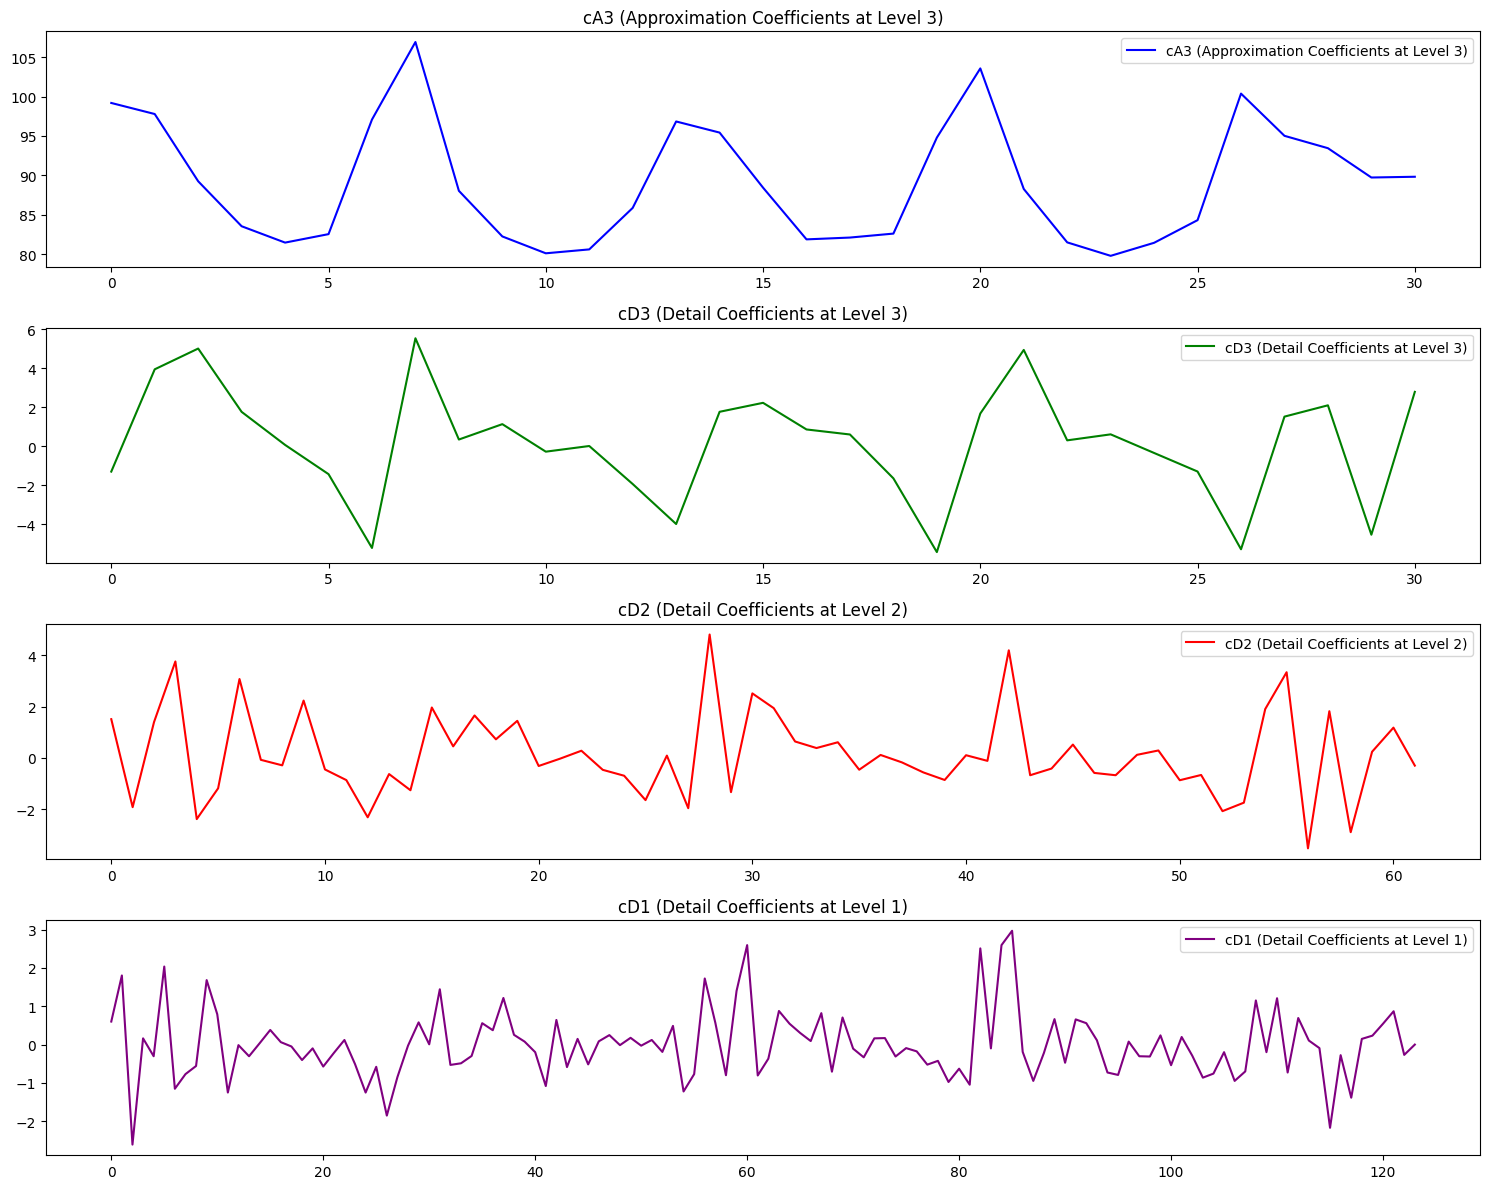

In [316]:
# Perform DWT on DRC_cases to decompose it
coeffs = pywt.wavedec(data['T2M_MAX'], wavelet='db1', level=3)
cA3, cD3, cD2, cD1 = coeffs

# Plot the coefficients
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(cA3, label="cA3 (Approximation Coefficients at Level 3)", color='blue')
axes[0].legend()
axes[0].set_title("cA3 (Approximation Coefficients at Level 3)")

axes[1].plot(cD3, label="cD3 (Detail Coefficients at Level 3)", color='green')
axes[1].legend()
axes[1].set_title("cD3 (Detail Coefficients at Level 3)")

axes[2].plot(cD2, label="cD2 (Detail Coefficients at Level 2)", color='red')
axes[2].legend()
axes[2].set_title("cD2 (Detail Coefficients at Level 2)")

axes[3].plot(cD1, label="cD1 (Detail Coefficients at Level 1)", color='purple')
axes[3].legend()
axes[3].set_title("cD1 (Detail Coefficients at Level 1)")

plt.tight_layout()
plt.show()


In [358]:
# Determine ARIMA parameters for cA3 series using auto_arima
arima_model_cA3 = auto_arima(cA3, seasonal=False, trace=True,
                             error_action='ignore', suppress_warnings=True,
                             stepwise=True)

# Display the best ARIMA parameters for cA3
arima_model_cA3.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=229.016, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=368.608, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=225.252, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=208.575, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=207.164, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=217.804, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=207.409, Time=0.04 sec
 ARIMA(1,0,0)(

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -100.582
Date:                Sun, 22 Oct 2023   AIC                            207.164
Time:                        19:08:15   BIC                            211.466
Sample:                             0   HQIC                           208.566
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     89.3170      2.247     39.751      0.000      84.913      93.721
ma.L1          0.6241      0.173      3.601      0.000       0.284       0.964
sigma2        37.9157     16.318      2.323      0.020       5.932      69.899
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 3.30
Prob(Q):                              0.56   Prob(JB):                         0.19
Heteroskedasticity (H):               0.77   Skew:                             0.68
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

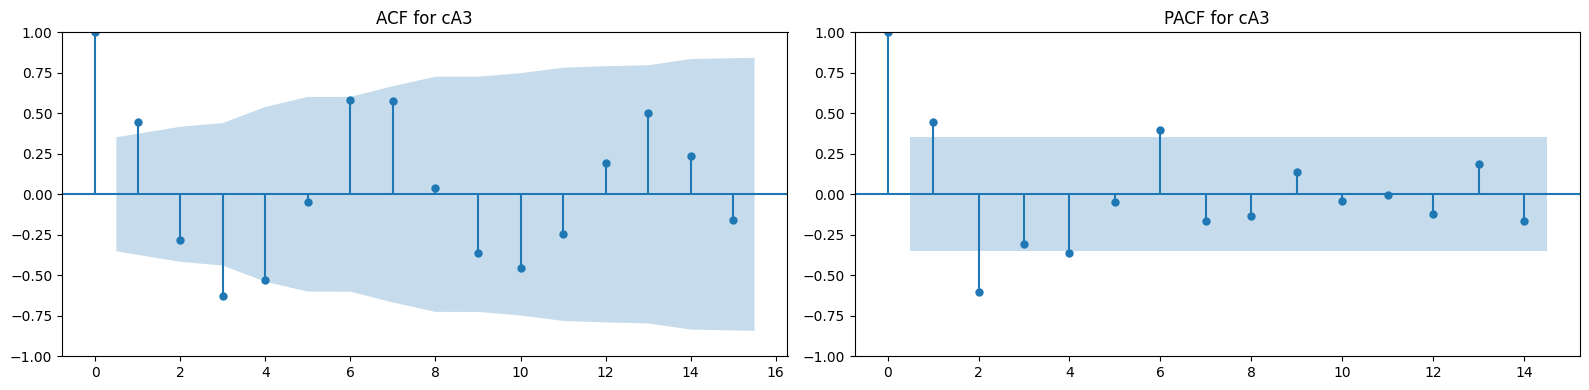

In [359]:
# Adjusting the number of lags for PACF
lags = len(cA3) // 2 - 1

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(cA3, ax=axes[0], title="ACF for cA3")

# Plot PACF with adjusted lags
plot_pacf(cA3, ax=axes[1], lags=lags, title="PACF for cA3")

plt.tight_layout()
plt.show()

In [360]:
# Number of forecast periods (for 2024)
forecast_periods = len(data['T2M_MAX']) // 62

# Forecast each coefficient series
forecast_cA3 = fit_and_forecast(cA3, forecast_periods)
forecast_cD3 = fit_and_forecast(cD3, forecast_periods)
forecast_cD2 = fit_and_forecast(cD2, forecast_periods)
forecast_cD1 = fit_and_forecast(cD1, forecast_periods)

forecast_cA3, forecast_cD3, forecast_cD2, forecast_cD1

(array([89.61739127, 89.52238604, 89.47865188]),
 array([0.14616557, 0.15128919, 0.15127927]),
 array([0.23717764, 0.11969062, 0.14538641]),
 array([-0.00351117, -0.00363724, -0.00364177]))

In [361]:
# Obtain in-sample predictions
predicted_cA3 = arima_cA3_fit.predict()

# Calculate MSE
mse_arima_T2M_MAX = mean_squared_error(cA3, predicted_cA3)
print(f"Mean Squared Error for ARIMA with DWT model: {mse_arima_T2M_MAX}")

Mean Squared Error for ARIMA with DWT model: 660.00744897277


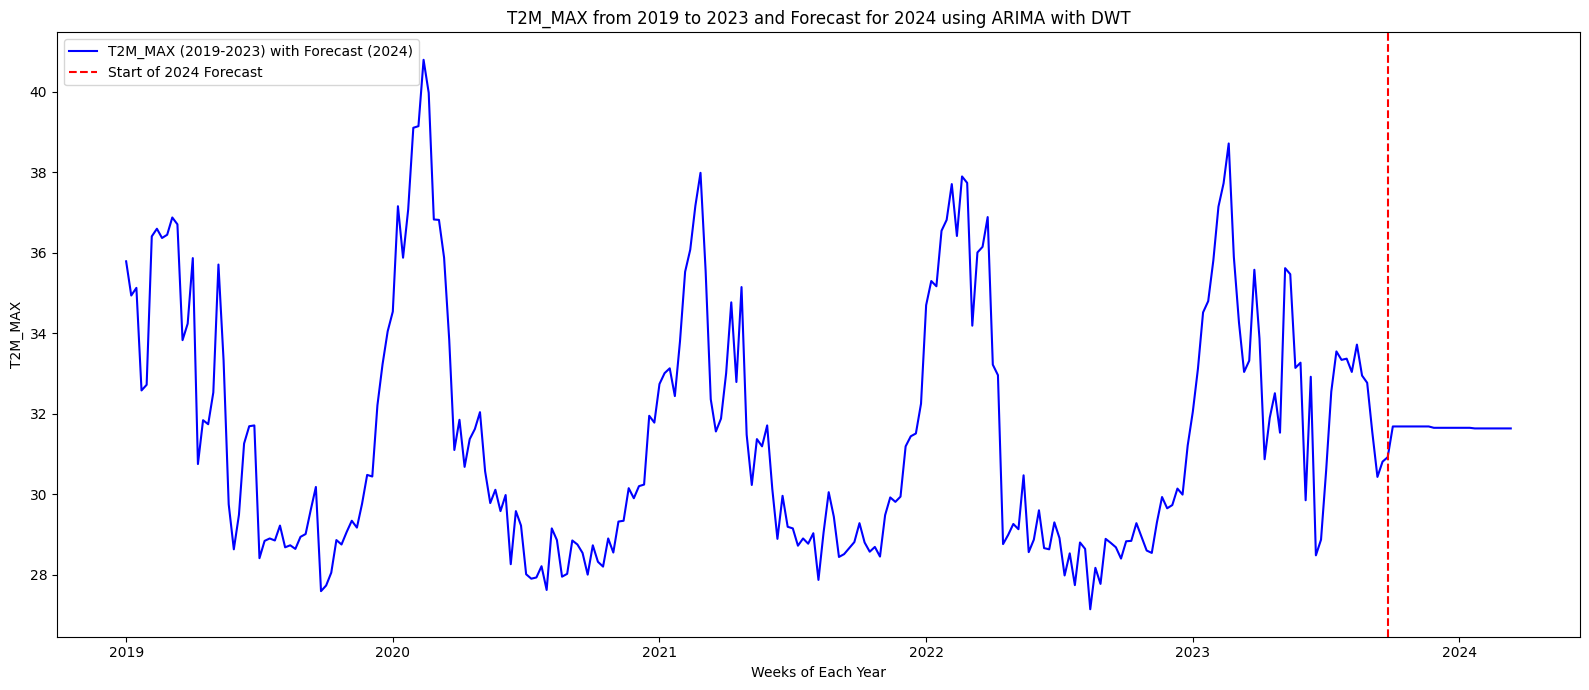

In [362]:
plot_arima(data['T2M_MAX'],'T2M_MAX')

## **SARIMAX on T2M_MAX**

In [322]:
# Lets try Sarimax also
sarimax_model_T2M_MAX = SARIMAX(data['T2M_MAX'],order=(1,1,1), seasonal_order =(1,1,1,52))
sarimax_fit_T2M_MAX = sarimax_model_T2M_MAX.fit()
sarimax_fit_T2M_MAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            T2M_MAX   No. Observations:                  247
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -353.095
Date:                            Sun, 22 Oct 2023   AIC                            716.189
Time:                                    18:49:31   BIC                            732.529
Sample:                                01-13-2019   HQIC                           722.806
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5656      0.078      7.243      0.000       0.413       0.719
ma.L1         -0.9178      0.044    -20.904      0.000      -1.004      -0.832
ar.S.L52       0.1632      0.175      0.930      0.352      -0.181       0.507
ma.S.L52      -0.9677      2.226     -0.435      0.664      -5.331       3.396
sigma2         1.6181      3.413      0.474      0.635      -5.070       8.307
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.84
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.00
Prob(H) (two-sided):                  0.87   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [323]:
#Extract AIC and BIC from ARIMA & SARIMAX model
sarimax_aic_T2M_MAX = sarimax_fit_T2M_MAX.aic
sarimax_bic_T2M_MAX = sarimax_fit_T2M_MAX.bic

sarimax_aic_T2M_MAX, sarimax_bic_T2M_MAX

(716.1892932825904, 732.528584077907)

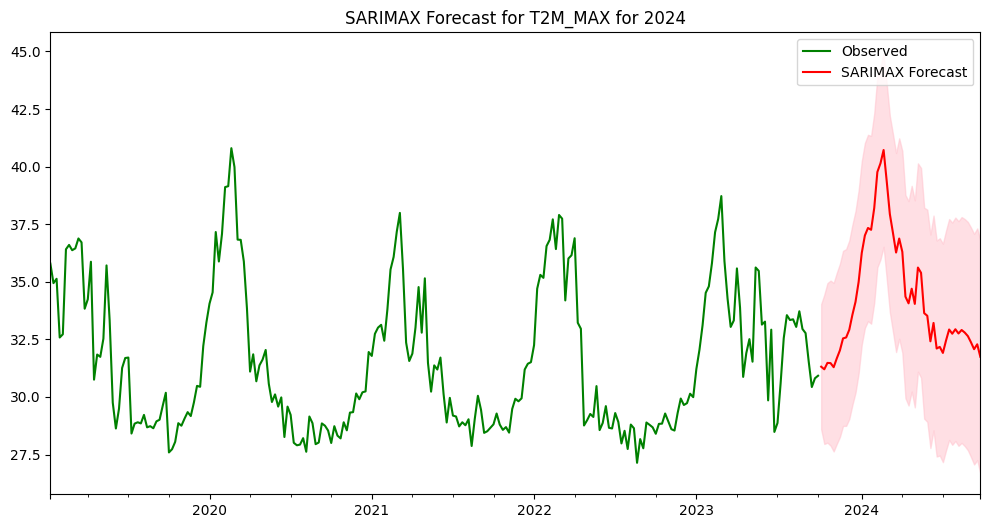

In [324]:
# Plot the forecasts and confidence intervals for 'sarimax_forecast'
sarimax_forecast_T2M_MAX =sarimax_fit_T2M_MAX.get_forecast(steps=52)
sarimax_forecast_mean_T2M_MAX = sarimax_forecast_T2M_MAX.predicted_mean

fig, ax = plt.subplots(figsize=(12, 6))
data['T2M_MAX'].plot(ax=ax, label='Observed',color='g')
sarimax_forecast_mean_T2M_MAX.plot(ax=ax, label='SARIMAX Forecast', color='r')
ci_sarimax_T2M_MAX = sarimax_forecast_T2M_MAX.conf_int()
ax.fill_between(ci_sarimax_T2M_MAX.index, ci_sarimax_T2M_MAX.iloc[:, 0], ci_sarimax_T2M_MAX.iloc[:, 1], color='pink',alpha=0.5)
plt.title("SARIMAX Forecast for T2M_MAX for 2024")
plt.legend()
plt.show()

In [325]:
SARIMAX_T2M_MAX_MSE = mean_squared_error(data['T2M_MAX'].iloc[-52:], sarimax_forecast_mean_T2M_MAX)
SARIMAX_T2M_MAX_MSE

6.006100390342765

## **Prophet on T2M_MAX**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/2j0pvh14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/mwig2e7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93270', 'data', 'file=/tmp/tmp0po00pk2/2j0pvh14.json', 'init=/tmp/tmp0po00pk2/mwig2e7m.json', 'output', 'file=/tmp/tmp0po00pk2/prophet_modelk46gzpqs/prophet_model-20231022190744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


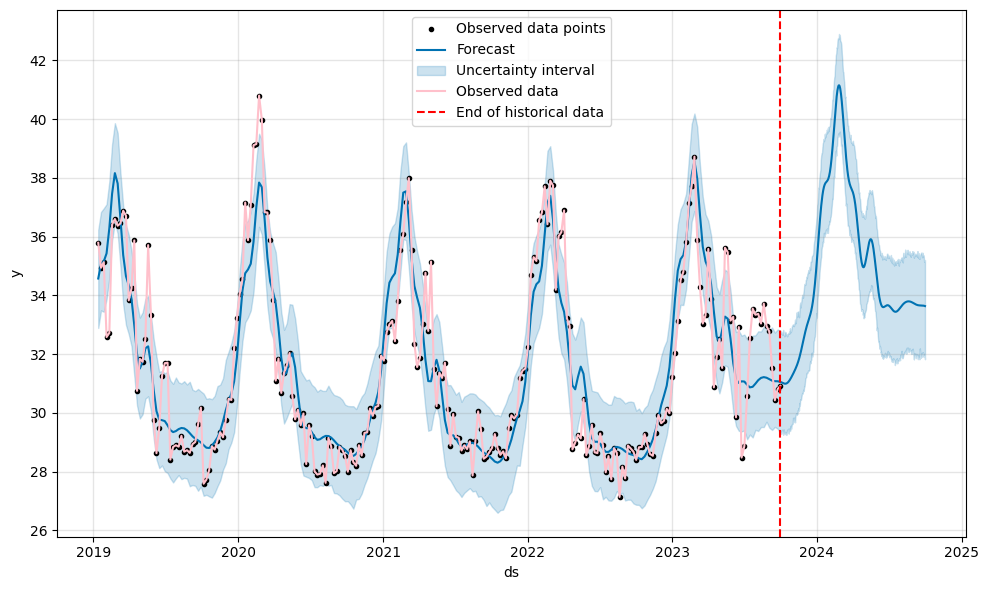

In [356]:
prophet_data = data.reset_index()
prophet_data.columns = ['ds', 'DRC_cases', 'DRC_deaths', 'PRECTOTCORR', 'T2M', 'y', 'T2M_MIN','DRC_cases_diff']
prophet_data = prophet_data[['ds', 'y']]

pr5=prof(prophet_data)

In [357]:
forecasted_values_1 = pr5['yhat'][:len(prophet_data)]
actual_values_1 = prophet_data['y']

# Calculate MSE
mse_5 = mean_squared_error(actual_values_1, forecasted_values_1)
print(f"Mean Squared Error for Prophet T2M_MAX: {mse_5}")

Mean Squared Error for Prophet T2M_MAX: 1.6913260952960947


In [363]:
print(f"Mean Squared Error \nARIMA:   {mse_arima_T2M_MAX}\nSARIMAX: {SARIMAX_T2M_MAX_MSE}\nProphet: {mse_5}")

Mean Squared Error 
ARIMA:   660.00744897277
SARIMAX: 6.006100390342765
Prophet: 1.6913260952960947


## Prophet outperforms the other two models for T2M_MAX

# **Analysis on T2M_MIN**

## ARIMA with DWT on T2M_MIN

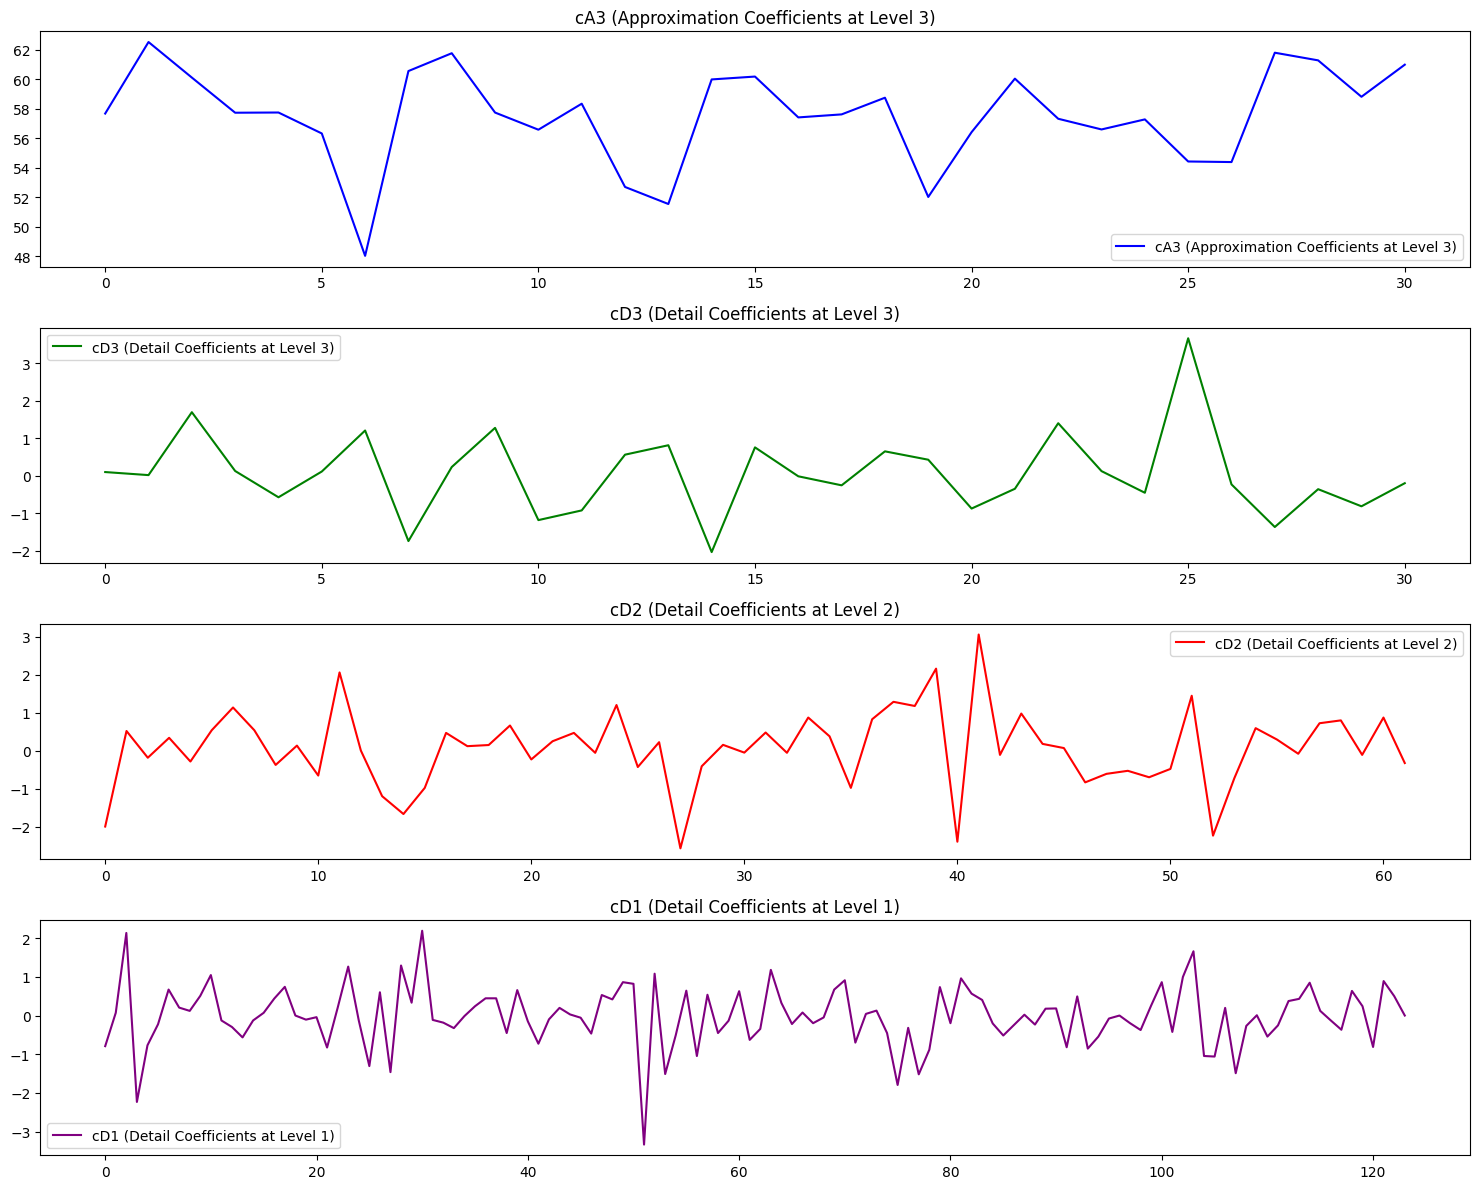

In [365]:
## Perform DWT on DRC_cases to decompose it
coeffs = pywt.wavedec(data['T2M_MIN'], wavelet='db1', level=3)
cA3, cD3, cD2, cD1 = coeffs

# Plot the coefficients
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(cA3, label="cA3 (Approximation Coefficients at Level 3)", color='blue')
axes[0].legend()
axes[0].set_title("cA3 (Approximation Coefficients at Level 3)")

axes[1].plot(cD3, label="cD3 (Detail Coefficients at Level 3)", color='green')
axes[1].legend()
axes[1].set_title("cD3 (Detail Coefficients at Level 3)")

axes[2].plot(cD2, label="cD2 (Detail Coefficients at Level 2)", color='red')
axes[2].legend()
axes[2].set_title("cD2 (Detail Coefficients at Level 2)")

axes[3].plot(cD1, label="cD1 (Detail Coefficients at Level 1)", color='purple')
axes[3].legend()
axes[3].set_title("cD1 (Detail Coefficients at Level 1)")

plt.tight_layout()
plt.show()


In [366]:
# Determine ARIMA parameters for cA3 series using auto_arima
arima_model_cA3 = auto_arima(cA3, seasonal=False, trace=True,
                             error_action='ignore', suppress_warnings=True,
                             stepwise=True)

# Display the best ARIMA parameters for cA3
arima_model_cA3.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=341.372, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=165.373, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=166.790, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=165.709, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=166.411, Time=0.24 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.003 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:                        SARIMAX   Log Likelihood                 -80.686
Date:                Sun, 22 Oct 2023   AIC                            165.373
Time:                        19:18:16   BIC                            168.241
Sample:                             0   HQIC                           166.307
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     57.5815      0.705     81.698      0.000      56.200      58.963
sigma2        10.6727      2.785      3.832      0.000       5.213      16.132
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 5.03
Prob(Q):                              0.43   Prob(JB):                         0.08
Heteroskedasticity (H):               0.48   Skew:                            -0.92
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

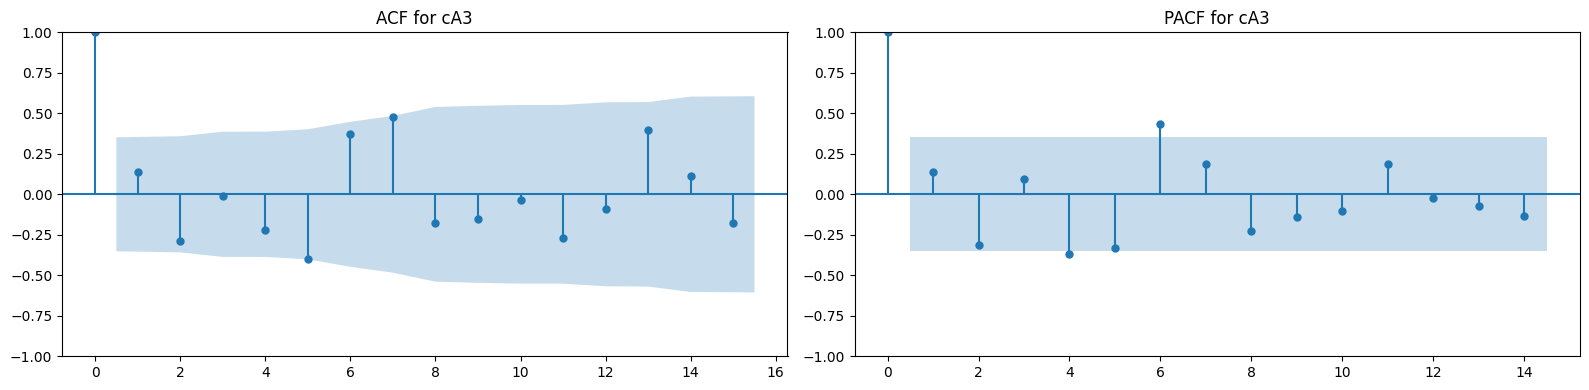

In [367]:
# Adjusting the number of lags for PACF
lags = len(cA3) // 2 - 1

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(cA3, ax=axes[0], title="ACF for cA3")

# Plot PACF with adjusted lags
plot_pacf(cA3, ax=axes[1], lags=lags, title="PACF for cA3")

plt.tight_layout()
plt.show()

In [368]:
# Number of forecast periods (for 2024)
forecast_periods = len(data['T2M_MIN']) // 62

# Forecast each coefficient series
forecast_cA3 = fit_and_forecast(cA3, forecast_periods)
forecast_cD3 = fit_and_forecast(cD3, forecast_periods)
forecast_cD2 = fit_and_forecast(cD2, forecast_periods)
forecast_cD1 = fit_and_forecast(cD1, forecast_periods)

forecast_cA3, forecast_cD3, forecast_cD2, forecast_cD1

(array([58.06480128, 57.6630318 , 57.60807702]),
 array([0.10884774, 0.05007442, 0.06133218]),
 array([0.1269447 , 0.06023518, 0.07008187]),
 array([-0.01771381, -0.0155016 , -0.01577788]))

In [369]:
# Obtain in-sample predictions
predicted_cA3 = arima_cA3_fit.predict()

# Calculate MSE
mse_arima_T2M_MIN = mean_squared_error(cA3, predicted_cA3)
print(f"Mean Squared Error for ARIMA with DWT model: {mse_arima_T2M_MIN}")

Mean Squared Error for ARIMA with DWT model: 299.2221468409493


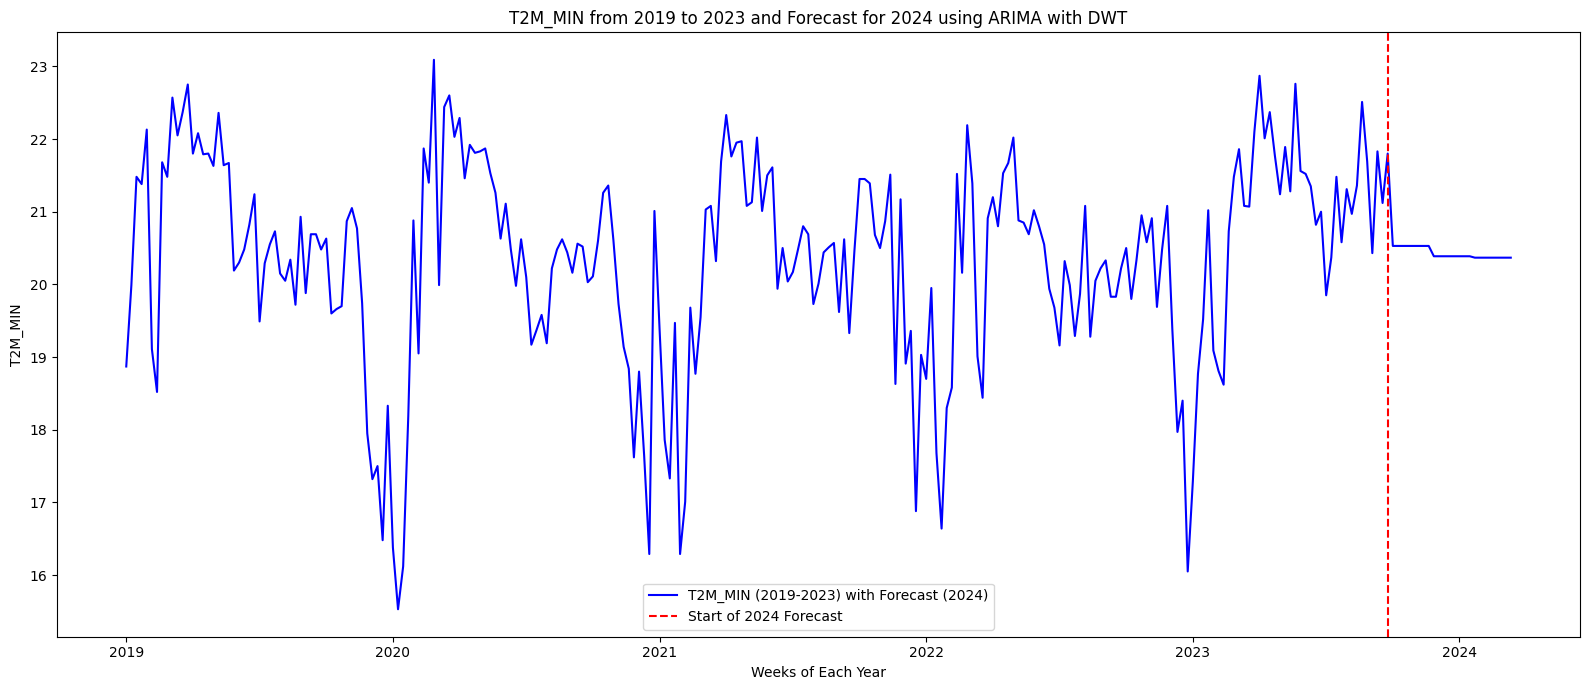

In [370]:
plot_arima(data['T2M_MIN'],'T2M_MIN')

## **SARIMAX for T2M_MIN**

In [371]:
# Lets try Sarimax also
sarimax_model_T2M_MIN = SARIMAX(data['T2M_MIN'],order=(1,1,1), seasonal_order =(1,1,1,52))
sarimax_fit_T2M_MIN = sarimax_model_T2M_MIN.fit()
sarimax_fit_T2M_MIN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            T2M_MIN   No. Observations:                  247
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -302.591
Date:                            Sun, 22 Oct 2023   AIC                            615.182
Time:                                    19:22:00   BIC                            631.521
Sample:                                01-13-2019   HQIC                           621.798
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3123      0.076      4.132      0.000       0.164       0.460
ma.L1         -0.9212      0.045    -20.425      0.000      -1.010      -0.833
ar.S.L52       0.0247      0.153      0.161      0.872      -0.276       0.325
ma.S.L52      -0.9972     32.930     -0.030      0.976     -65.540      63.545
sigma2         0.8807     28.907      0.030      0.976     -55.776      57.537
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               125.46
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.66
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [372]:
#Extract AIC and BIC from ARIMA & SARIMAX model
sarimax_aic_T2M_MIN = sarimax_fit_T2M_MIN.aic
sarimax_bic_T2M_MIN = sarimax_fit_T2M_MIN.bic

sarimax_aic_T2M_MIN, sarimax_bic_T2M_MIN

(615.1820508823985, 631.5213416777151)

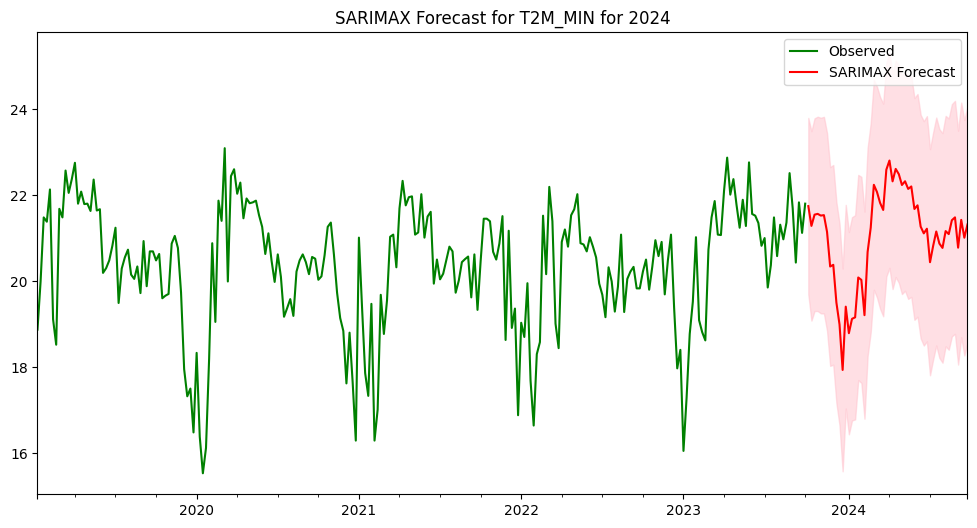

In [373]:
# Plot the forecasts and confidence intervals for 'sarimax_forecast'
sarimax_forecast_T2M_MIN =sarimax_fit_T2M_MIN.get_forecast(steps=52)
sarimax_forecast_mean_T2M_MIN = sarimax_forecast_T2M_MIN.predicted_mean

fig, ax = plt.subplots(figsize=(12, 6))
data['T2M_MIN'].plot(ax=ax, label='Observed',color='g')
sarimax_forecast_mean_T2M_MIN.plot(ax=ax, label='SARIMAX Forecast', color='r')
ci_sarimax_T2M_MIN = sarimax_forecast_T2M_MIN.conf_int()
ax.fill_between(ci_sarimax_T2M_MIN.index, ci_sarimax_T2M_MIN.iloc[:, 0], ci_sarimax_T2M_MIN.iloc[:, 1], color='pink',alpha=0.5)
plt.title("SARIMAX Forecast for T2M_MIN for 2024")
plt.legend()
plt.show()

In [374]:
SARIMAX_T2M_MIN_MSE = mean_squared_error(data['T2M_MIN'].iloc[-52:], sarimax_forecast_mean_T2M_MIN)
SARIMAX_T2M_MIN_MSE

0.7440940054636875

## **Prophet Model on T2M_MIN**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/u8y_c_wr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0po00pk2/mewn5khe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91150', 'data', 'file=/tmp/tmp0po00pk2/u8y_c_wr.json', 'init=/tmp/tmp0po00pk2/mewn5khe.json', 'output', 'file=/tmp/tmp0po00pk2/prophet_modelhhrcjcvz/prophet_model-20231022192340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:23:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


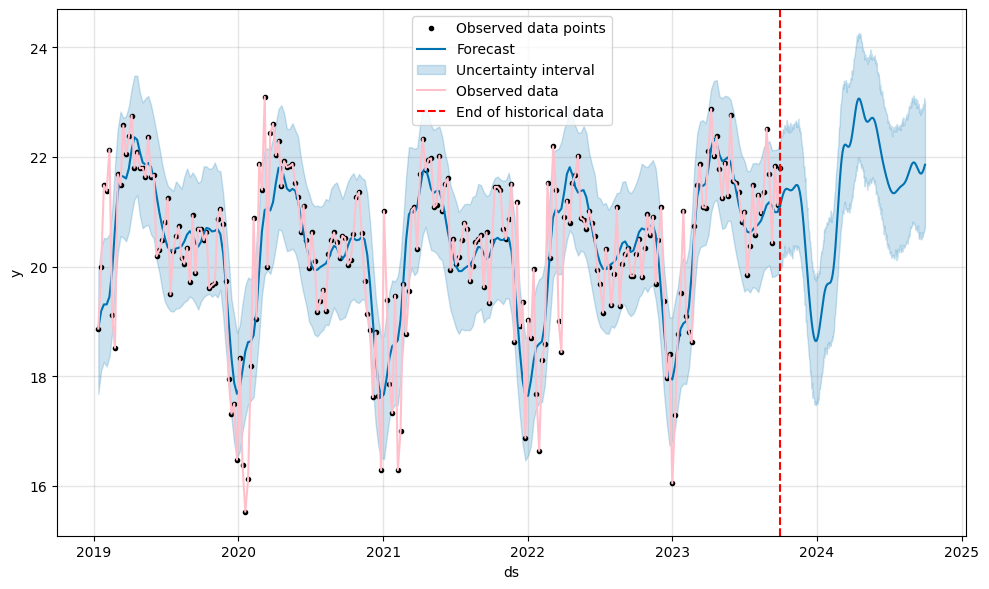

In [375]:
prophet_data = data.reset_index()
prophet_data.columns = ['ds', 'DRC_cases', 'DRC_deaths', 'PRECTOTCORR', 'T2M', 'T2M_MAX', 'y','DRC_cases_diff']
prophet_data = prophet_data[['ds', 'y']]

pr6=prof(prophet_data)

In [376]:
forecasted_values_1 = pr6['yhat'][:len(prophet_data)]
actual_values_1 = prophet_data['y']

# Calculate MSE
mse_6 = mean_squared_error(actual_values_1, forecasted_values_1)
print(f"Mean Squared Error for Prophet T2M_MAX: {mse_6}")

Mean Squared Error for Prophet T2M_MAX: 0.7854074043652981


In [377]:
print(f"Mean Squared Error \nARIMA:   {mse_arima_T2M_MIN}\nSARIMAX: {SARIMAX_T2M_MIN_MSE}\nProphet: {mse_6}")

Mean Squared Error 
ARIMA:   299.2221468409493
SARIMAX: 0.7440940054636875
Prophet: 0.7854074043652981


# All Prophet Models in a single chart

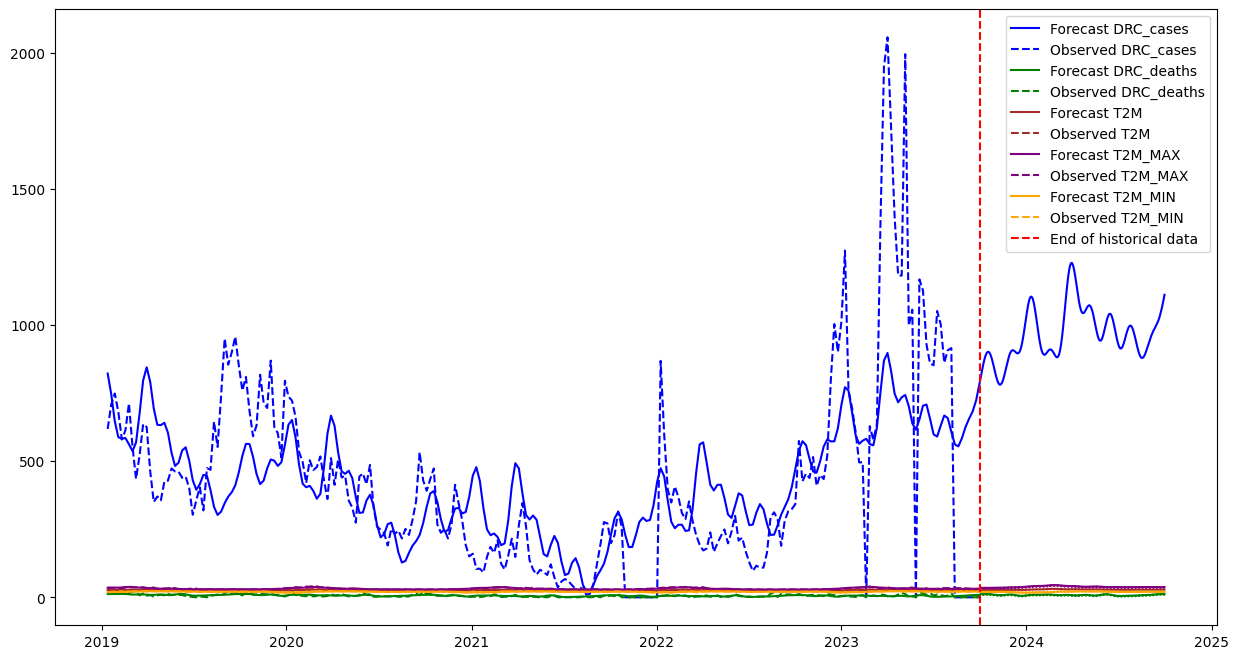

In [406]:

# Updated list of columns to forecast
columns_to_forecast = ['DRC_cases', 'DRC_deaths', 'T2M', 'T2M_MAX', 'T2M_MIN']

# List of colors for plotting
colors = ['blue', 'green', 'brown', 'purple', 'orange']
df=data.reset_index()
# Initialize a plot
plt.figure(figsize=(15, 8))

# Loop through each column and forecast
for idx, col in enumerate(columns_to_forecast):
    prophet_data = df[['index', col]].copy()  # Create a deep copy of the subset
    prophet_data.columns = ['ds', 'target']  # Rename columns

    # Now, only rename 'target' to 'y'
    prophet_data = prophet_data.rename(columns={'target': 'y'})

    model = Prophet(weekly_seasonality=True)
    model.fit(prophet_data)

    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)

    # Plot the forecast
    plt.plot(forecast['ds'], forecast['yhat'], color=colors[idx], label=f'Forecast {col}')

    # Plot the observed data with the same color
    plt.plot(df['index'], df[col], color=colors[idx], linestyle='--', label=f'Observed {col}')

# Highlight the forecast period with a vertical line
last_date = df['index'].max()
plt.axvline(x=last_date, color='red', linestyle='--', label='End of historical data')

# Display the legend and show the plot
plt.legend()
plt.show()


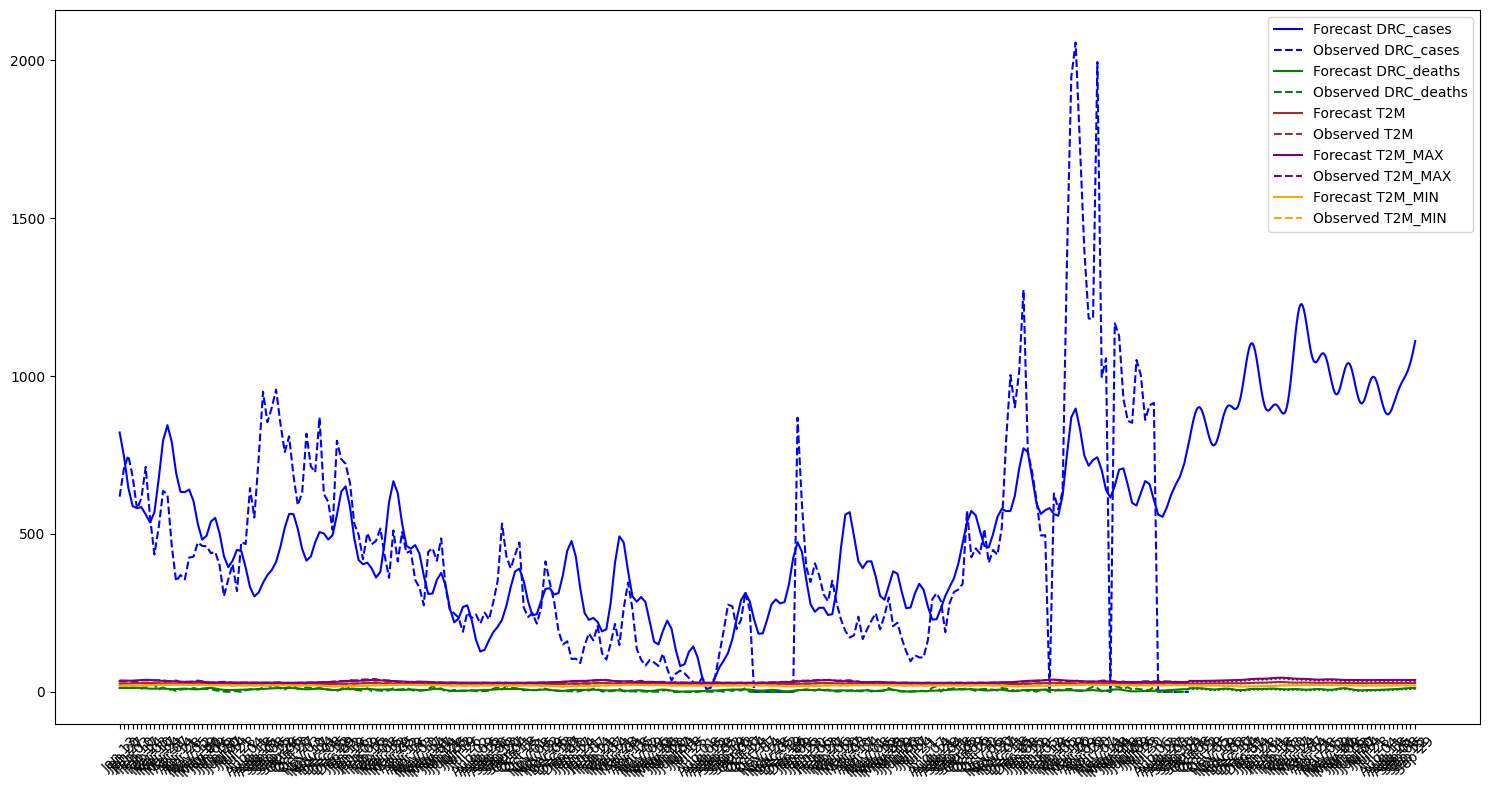

In [ ]:
import matplotlib.dates as mdates
plt.figure(figsize=(15, 8))
for idx, col in enumerate(columns_to_forecast):
    prophet_data = df[['index', col]].copy()  # Create a deep copy of the subset
    prophet_data.columns = ['ds', 'target']  # Rename columns

    # Now, only rename 'target' to 'y'
    prophet_data = prophet_data.rename(columns={'target': 'y'})

    model = Prophet(weekly_seasonality=True)
    model.fit(prophet_data)

    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)

    # Plot the forecast
    plt.plot(forecast['ds'], forecast['yhat'], color=colors[idx], label=f'Forecast {col}')

    # Plot the observed data with the same color
    plt.plot(df['index'], df[col], color=colors[idx], linestyle='--', label=f'Observed {col}')

# Highlight the forecast period with a vertical line
date_range = pd.date_range(start=df['index'].min(), end=forecast['ds'].max(), freq='W')

plt.xticks(ticks=date_range, labels=[dt.strftime('%b %d') for dt in date_range], rotation=45)

# Adjust layout for better display
plt.tight_layout()

plt.legend()
plt.show()